Loading functions

In [1]:
%load_ext autoreload
%autoreload 2

from utils import *
from dual import *

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### voice data prep

In [29]:
#voice_shuffle = pd.read_csv('voice.csv').sample(frac=1)
#save_file('voice_numsamp_shuffle_full', voice_shuffle)

In [12]:
def voice_prep(data, dupes):
    
    # Not taking random samples - using cumulative instead
    # data = data[:samples]  # data.sample(samples)
    
    data_size = len(data.index)

    voice_X = data.iloc[:, :-1]
    voice_y = data.iloc[:, -1]

    # code categories to -1/1
    gender_encoder = LabelEncoder()
    voice_y = np.array(gender_encoder.fit_transform(voice_y))
    voice_y = voice_y * 2 - 1

    # normalize data
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(voice_X)
    voice_X = np.array(scaler.transform(voice_X))
    voice_X = voice_X[:,0:2]
    
    voice_X = np.tile(voice_X, dupes)
    
    return voice_X, voice_y

In [15]:
data_voice = load_file('voice500')
voice_X, voice_y = voice_prep(data_voice, 4)

In [16]:
voice_X

array([[ 0.8321637 , -0.74410499,  0.8321637 , ..., -0.74410499,
         0.8321637 , -0.74410499],
       [-0.23953948, -0.04045926, -0.23953948, ..., -0.04045926,
        -0.23953948, -0.04045926],
       [ 0.7101093 , -0.60454612,  0.7101093 , ..., -0.60454612,
         0.7101093 , -0.60454612],
       ...,
       [ 0.61128825, -0.16734443,  0.61128825, ..., -0.16734443,
         0.61128825, -0.16734443],
       [ 0.16217263, -0.09375893,  0.16217263, ..., -0.09375893,
         0.16217263, -0.09375893],
       [-0.2663575 ,  0.26587904, -0.2663575 , ...,  0.26587904,
        -0.2663575 ,  0.26587904]])

# Calculating rademacher for different bounds / margins

In [24]:
BOUNDS = np.array([1e-12]) #, 0.5, 1.0])
MARGINS = np.array([0, 0.5, 1.0, 2.0])

dupes = [1, 2, 4, 8]

# PUMP_X = voice_X
# PUMP_Y = voice_y

runs_per_sample = 5
maxiter = 100
init_temp = 5500
accept = -5

pump_cycles = 900

In [25]:
for dupe in dupes:
    
    PUMP_X, PUMP_Y = voice_prep(data_voice, dupe)
    
    for pc in range(pump_cycles):
        # generate rademacher vector
        radvec = [rd.randint(0, 1) * 2 - 1 for x in range(PUMP_X.shape[0])]
        
        print('\n', dupe, ':', pc, '///')

        for b in BOUNDS:
            ## Calculate Confidence Rademacher Complexity
            DATA_SAVE_NAME = "histories/dupes/voice_dupes"+str(dupe)+"_maxiter100_confidence_b"+str(b)

            try:
                history = load_file(DATA_SAVE_NAME)
            except:
                print('creating new file')
                history = RDhistory('confidence')

            pump_rademacher(PUMP_X, PUMP_Y,
                            history=history,
                            radvec=radvec,
                            runs_per_sample=1,
                            margin=1.0, bound=b,
                            verbose=False)

            save_file(DATA_SAVE_NAME, history)

            ## Calculate Margin loss Rademacher Complexity for all the margins
            for mar in MARGINS:
                # print(mar, end=' ')

                DATA_SAVE_NAME = "histories/dupes/voice_dupes"+str(dupe)+"_maxiter100_margin_loss_b" + str(b) + '_m' + str(mar)

                try:
                    history = load_file(DATA_SAVE_NAME)
                except:
                    print('new file', end=' ')
                    history = RDhistory('margin_loss')

                pump_rademacher(PUMP_X, PUMP_Y,
                                history=history,
                                radvec=radvec,
                                runs_per_sample=runs_per_sample,
                                margin=mar, bound=b,
                                verbose=False,
                                method='da', kwargs={'maxiter':maxiter, 'initial_temp':init_temp, 'accept':accept})

                save_file(DATA_SAVE_NAME, history)


 1 : 0 ///
b:  1e-12 	m:  1.0 	c:  23.223356472647072
b:  1e-12 	m:  0.0 	c:  19.0
b:  1e-12 	m:  0.5 	c:  11.657944120781018
b:  1e-12 	m:  1.0 	c:  10.780357228572086
b:  1e-12 	m:  2.0 	c:  10.390178613668361

 1 : 1 ///
b:  1e-12 	m:  1.0 	c:  17.519208626727927
b:  1e-12 	m:  0.0 	c:  28.0
b:  1e-12 	m:  0.5 	c:  21.456625060841723
b:  1e-12 	m:  1.0 	c:  21.904458981696145
b:  1e-12 	m:  2.0 	c:  22.952229491017356

 1 : 2 ///
b:  1e-12 	m:  1.0 	c:  21.163471287929553
b:  1e-12 	m:  0.0 	c:  6.0
b:  1e-12 	m:  0.5 	c:  -5.2769371488426735
b:  1e-12 	m:  1.0 	c:  -7.969723093665891
b:  1e-12 	m:  2.0 	c:  -12.110041407786941

 1 : 3 ///
b:  1e-12 	m:  1.0 	c:  3.3694585553946323
b:  1e-12 	m:  0.0 	c:  44.0
b:  1e-12 	m:  0.5 	c:  32.59965930740486
b:  1e-12 	m:  1.0 	c:  28.58385122639214
b:  1e-12 	m:  2.0 	c:  26.291925615672564

 1 : 4 ///
b:  1e-12 	m:  1.0 	c:  10.631792716939952
b:  1e-12 	m:  0.0 	c:  25.0
b:  1e-12 	m:  0.5 	c:  20.96946649748721
b:  1e-12 	m:  1.0 	c: 

b:  1e-12 	m:  1.0 	c:  48.3941018558518
b:  1e-12 	m:  2.0 	c:  48.19705092809434

 1 : 39 ///
b:  1e-12 	m:  1.0 	c:  19.392176468628243
b:  1e-12 	m:  0.0 	c:  6.0
b:  1e-12 	m:  0.5 	c:  -15.475674608697226
b:  1e-12 	m:  1.0 	c:  -16.564882836162305
b:  1e-12 	m:  2.0 	c:  -24.050576842627763

 1 : 40 ///
b:  1e-12 	m:  1.0 	c:  33.553516066830575
b:  1e-12 	m:  0.0 	c:  27.0
b:  1e-12 	m:  0.5 	c:  16.274354281604968
b:  1e-12 	m:  1.0 	c:  12.543099799171294
b:  1e-12 	m:  2.0 	c:  -0.01908037734462731

 1 : 41 ///
b:  1e-12 	m:  1.0 	c:  15.671787337083515
b:  1e-12 	m:  0.0 	c:  27.0
b:  1e-12 	m:  0.5 	c:  19.910341477170974
b:  1e-12 	m:  1.0 	c:  15.420343786313468
b:  1e-12 	m:  2.0 	c:  9.885484057396747

 1 : 42 ///
b:  1e-12 	m:  1.0 	c:  7.712887240371641
b:  1e-12 	m:  0.0 	c:  19.0
b:  1e-12 	m:  0.5 	c:  6.925113654645189
b:  1e-12 	m:  1.0 	c:  6.801256472572032
b:  1e-12 	m:  2.0 	c:  0.05820508909679578

 1 : 43 ///
b:  1e-12 	m:  1.0 	c:  8.253091214008986
b:  1

b:  1e-12 	m:  0.0 	c:  33.0
b:  1e-12 	m:  0.5 	c:  19.493096604770578
b:  1e-12 	m:  1.0 	c:  15.699889046794109
b:  1e-12 	m:  2.0 	c:  13.849944523643508

 1 : 78 ///
b:  1e-12 	m:  1.0 	c:  2.0055431395033025
b:  1e-12 	m:  0.0 	c:  25.0
b:  1e-12 	m:  0.5 	c:  22.964697611468644
b:  1e-12 	m:  1.0 	c:  21.524178961740247
b:  1e-12 	m:  2.0 	c:  19.753174057151845

 1 : 79 ///
b:  1e-12 	m:  1.0 	c:  11.54658442016156
b:  1e-12 	m:  0.0 	c:  14.0
b:  1e-12 	m:  0.5 	c:  4.388252564852329
b:  1e-12 	m:  1.0 	c:  3.6023781684253326
b:  1e-12 	m:  2.0 	c:  1.0049847275168702

 1 : 80 ///
b:  1e-12 	m:  1.0 	c:  8.31613855537661
b:  1e-12 	m:  0.0 	c:  33.0
b:  1e-12 	m:  0.5 	c:  28.04476668922452
b:  1e-12 	m:  1.0 	c:  24.50077876031144
b:  1e-12 	m:  2.0 	c:  23.250389380803853

 1 : 81 ///
b:  1e-12 	m:  1.0 	c:  34.15984516407086
b:  1e-12 	m:  0.0 	c:  37.0
b:  1e-12 	m:  0.5 	c:  38.55045738988171
b:  1e-12 	m:  1.0 	c:  36.0017777646031
b:  1e-12 	m:  2.0 	c:  25.335883961506

b:  1e-12 	m:  2.0 	c:  -17.138146507060856

 1 : 116 ///
b:  1e-12 	m:  1.0 	c:  7.524332305768494
b:  1e-12 	m:  0.0 	c:  34.0
b:  1e-12 	m:  0.5 	c:  20.578881186985143
b:  1e-12 	m:  1.0 	c:  16.868291081664463
b:  1e-12 	m:  2.0 	c:  15.434145540775523

 1 : 117 ///
b:  1e-12 	m:  1.0 	c:  4.442670072071879
b:  1e-12 	m:  0.0 	c:  19.0
b:  1e-12 	m:  0.5 	c:  1.655149566072902
b:  1e-12 	m:  1.0 	c:  -1.1408262061744097
b:  1e-12 	m:  2.0 	c:  -2.570413103312804

 1 : 118 ///
b:  1e-12 	m:  1.0 	c:  18.797716102487513
b:  1e-12 	m:  0.0 	c:  7.0
b:  1e-12 	m:  0.5 	c:  1.5055492963198374
b:  1e-12 	m:  1.0 	c:  1.1629485919166633
b:  1e-12 	m:  2.0 	c:  -2.9491525491476516

 1 : 119 ///
b:  1e-12 	m:  1.0 	c:  31.848874750606278
b:  1e-12 	m:  0.0 	c:  53.0
b:  1e-12 	m:  0.5 	c:  34.22135642044305
b:  1e-12 	m:  1.0 	c:  27.870822241064463
b:  1e-12 	m:  2.0 	c:  23.93541112060293

 1 : 120 ///
b:  1e-12 	m:  1.0 	c:  5.159617163403455
b:  1e-12 	m:  0.0 	c:  44.0
b:  1e-12 	m:  

b:  1e-12 	m:  0.0 	c:  27.0
b:  1e-12 	m:  0.5 	c:  6.162808247269464
b:  1e-12 	m:  1.0 	c:  -0.6897116002742258
b:  1e-12 	m:  2.0 	c:  -9.263560146316173

 1 : 155 ///
b:  1e-12 	m:  1.0 	c:  11.957608998081655
b:  1e-12 	m:  0.0 	c:  27.0
b:  1e-12 	m:  0.5 	c:  26.79051185224364
b:  1e-12 	m:  1.0 	c:  23.023532894623322
b:  1e-12 	m:  2.0 	c:  21.511766446851784

 1 : 156 ///
b:  1e-12 	m:  1.0 	c:  6.797122575228408
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  32.142977414938514
b:  1e-12 	m:  1.0 	c:  34.33765503957471
b:  1e-12 	m:  2.0 	c:  36.16882751960891

 1 : 157 ///
b:  1e-12 	m:  1.0 	c:  2.96842832408526
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  8.52008380985534
b:  1e-12 	m:  1.0 	c:  3.48634094298097
b:  1e-12 	m:  2.0 	c:  -4.242726151356001

 1 : 158 ///
b:  1e-12 	m:  1.0 	c:  7.294230061780422
b:  1e-12 	m:  0.0 	c:  12.0
b:  1e-12 	m:  0.5 	c:  5.538182791712199
b:  1e-12 	m:  1.0 	c:  -1.284775599273738
b:  1e-12 	m:  2.0 	c:  -5.6372248858

b:  1e-12 	m:  2.0 	c:  -55.63004500299908

 1 : 193 ///
b:  1e-12 	m:  1.0 	c:  6.026677044059071
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  8.488947402173745
b:  1e-12 	m:  1.0 	c:  5.552270029695125
b:  1e-12 	m:  2.0 	c:  3.7761350147188857

 1 : 194 ///
b:  1e-12 	m:  1.0 	c:  0.7908508897547044
b:  1e-12 	m:  0.0 	c:  14.0
b:  1e-12 	m:  0.5 	c:  0.4060501169738444
b:  1e-12 	m:  1.0 	c:  -5.610818460950302
b:  1e-12 	m:  2.0 	c:  -9.805409230464887

 1 : 195 ///
b:  1e-12 	m:  1.0 	c:  9.854480011656596
b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m:  0.5 	c:  3.0259600716282513
b:  1e-12 	m:  1.0 	c:  -5.103551602792457
b:  1e-12 	m:  2.0 	c:  -7.868598853579338

 1 : 196 ///
b:  1e-12 	m:  1.0 	c:  4.5541501338315795
b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:  0.5 	c:  10.501074611750068
b:  1e-12 	m:  1.0 	c:  7.35924865540963
b:  1e-12 	m:  2.0 	c:  4.836229752879003

 1 : 197 ///
b:  1e-12 	m:  1.0 	c:  29.787879507236564
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5

b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  18.792492015765095
b:  1e-12 	m:  1.0 	c:  10.986495928161098
b:  1e-12 	m:  2.0 	c:  7.487865582078387

 1 : 232 ///
b:  1e-12 	m:  1.0 	c:  12.628063375188244
b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:  0.5 	c:  11.145135521771195
b:  1e-12 	m:  1.0 	c:  9.971227193206527
b:  1e-12 	m:  2.0 	c:  3.8979847658328586

 1 : 233 ///
b:  1e-12 	m:  1.0 	c:  16.83474283648381
b:  1e-12 	m:  0.0 	c:  9.0
b:  1e-12 	m:  0.5 	c:  7.846269307759984
b:  1e-12 	m:  1.0 	c:  6.310340535139983
b:  1e-12 	m:  2.0 	c:  2.9926672817820323

 1 : 234 ///
b:  1e-12 	m:  1.0 	c:  4.638057263738309
b:  1e-12 	m:  0.0 	c:  17.0
b:  1e-12 	m:  0.5 	c:  7.735209741790349
b:  1e-12 	m:  1.0 	c:  2.138286353715265
b:  1e-12 	m:  2.0 	c:  -1.930856849250512

 1 : 235 ///
b:  1e-12 	m:  1.0 	c:  39.59359657789204
b:  1e-12 	m:  0.0 	c:  21.0
b:  1e-12 	m:  0.5 	c:  1.1326346790578832
b:  1e-12 	m:  1.0 	c:  -0.01730586621740926
b:  1e-12 	m:  2.0 	c:  -8.883299

b:  1e-12 	m:  2.0 	c:  3.970834992987676

 1 : 270 ///
b:  1e-12 	m:  1.0 	c:  15.30983701259902
b:  1e-12 	m:  0.0 	c:  30.0
b:  1e-12 	m:  0.5 	c:  30.16308684661697
b:  1e-12 	m:  1.0 	c:  30.034284993665977
b:  1e-12 	m:  2.0 	c:  30.01714249684838

 1 : 271 ///
b:  1e-12 	m:  1.0 	c:  13.640125121315643
b:  1e-12 	m:  0.0 	c:  35.0
b:  1e-12 	m:  0.5 	c:  20.696388978950413
b:  1e-12 	m:  1.0 	c:  15.096861611739238
b:  1e-12 	m:  2.0 	c:  12.548430806755574

 1 : 272 ///
b:  1e-12 	m:  1.0 	c:  24.035748181578757
b:  1e-12 	m:  0.0 	c:  37.0
b:  1e-12 	m:  0.5 	c:  32.58777673062326
b:  1e-12 	m:  1.0 	c:  29.863581670278865
b:  1e-12 	m:  2.0 	c:  26.931790835139115

 1 : 273 ///
b:  1e-12 	m:  1.0 	c:  20.107298233988708
b:  1e-12 	m:  0.0 	c:  44.0
b:  1e-12 	m:  0.5 	c:  29.410945930578045
b:  1e-12 	m:  1.0 	c:  24.998921086724152
b:  1e-12 	m:  2.0 	c:  22.499460543106498

 1 : 274 ///
b:  1e-12 	m:  1.0 	c:  6.210349275610415
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.

b:  1e-12 	m:  0.0 	c:  3.0
b:  1e-12 	m:  0.5 	c:  -8.377433059637468
b:  1e-12 	m:  1.0 	c:  -13.675304257247566
b:  1e-12 	m:  2.0 	c:  -21.37958840762274

 1 : 309 ///
b:  1e-12 	m:  1.0 	c:  27.782279126284386
b:  1e-12 	m:  0.0 	c:  5.0
b:  1e-12 	m:  0.5 	c:  -7.937756040569596
b:  1e-12 	m:  1.0 	c:  -8.442747796813514
b:  1e-12 	m:  2.0 	c:  -20.773863104797478

 1 : 310 ///
b:  1e-12 	m:  1.0 	c:  9.852265039475236
b:  1e-12 	m:  0.0 	c:  13.0
b:  1e-12 	m:  0.5 	c:  11.579139104859571
b:  1e-12 	m:  1.0 	c:  3.645988492628647
b:  1e-12 	m:  2.0 	c:  0.8229942476516703

 1 : 311 ///
b:  1e-12 	m:  1.0 	c:  10.475381191182581
b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:  0.5 	c:  18.248569917230462
b:  1e-12 	m:  1.0 	c:  18.5957526686869
b:  1e-12 	m:  2.0 	c:  18.297876334868274

 1 : 312 ///
b:  1e-12 	m:  1.0 	c:  2.5976468290729624
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  10.563474339018391
b:  1e-12 	m:  1.0 	c:  6.312554913442678
b:  1e-12 	m:  2.0 	c:  4.1562

b:  1e-12 	m:  2.0 	c:  12.868835321278853

 1 : 347 ///
b:  1e-12 	m:  1.0 	c:  4.750867075645787
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  19.00852053742159
b:  1e-12 	m:  1.0 	c:  14.41925072526585
b:  1e-12 	m:  2.0 	c:  10.209625362748037

 1 : 348 ///
b:  1e-12 	m:  1.0 	c:  5.226745694925491
b:  1e-12 	m:  0.0 	c:  4.0
b:  1e-12 	m:  0.5 	c:  -19.075891699688352
b:  1e-12 	m:  1.0 	c:  -23.195466311917144
b:  1e-12 	m:  2.0 	c:  -27.601460097033403

 1 : 349 ///
b:  1e-12 	m:  1.0 	c:  41.912611118048815
b:  1e-12 	m:  0.0 	c:  12.0
b:  1e-12 	m:  0.5 	c:  -8.7401828861159
b:  1e-12 	m:  1.0 	c:  -11.977794664101056
b:  1e-12 	m:  2.0 	c:  -23.311304377147366

 1 : 350 ///
b:  1e-12 	m:  1.0 	c:  5.538032250330483
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  13.399094674785925
b:  1e-12 	m:  1.0 	c:  8.236954473988895
b:  1e-12 	m:  2.0 	c:  6.125489966071841

 1 : 351 ///
b:  1e-12 	m:  1.0 	c:  32.202165568354346
b:  1e-12 	m:  0.0 	c:  -2.0
b:  1e-12 	m:  0

b:  1e-12 	m:  0.0 	c:  29.0
b:  1e-12 	m:  0.5 	c:  20.985035643787697
b:  1e-12 	m:  1.0 	c:  23.17394830285294
b:  1e-12 	m:  2.0 	c:  23.58697414604721

 1 : 386 ///
b:  1e-12 	m:  1.0 	c:  11.628117322641913
b:  1e-12 	m:  0.0 	c:  16.0
b:  1e-12 	m:  0.5 	c:  4.0258326584710495
b:  1e-12 	m:  1.0 	c:  2.737780893084622
b:  1e-12 	m:  2.0 	c:  -2.928564803095469

 1 : 387 ///
b:  1e-12 	m:  1.0 	c:  15.213605044617843
b:  1e-12 	m:  0.0 	c:  18.0
b:  1e-12 	m:  0.5 	c:  12.441390141962644
b:  1e-12 	m:  1.0 	c:  11.972115025877681
b:  1e-12 	m:  2.0 	c:  11.986057513289307

 1 : 388 ///
b:  1e-12 	m:  1.0 	c:  3.221281113445596
b:  1e-12 	m:  0.0 	c:  13.0
b:  1e-12 	m:  0.5 	c:  7.403351522813443
b:  1e-12 	m:  1.0 	c:  5.912401216952002
b:  1e-12 	m:  2.0 	c:  3.956200608140049

 1 : 389 ///
b:  1e-12 	m:  1.0 	c:  4.45987355035753
b:  1e-12 	m:  0.0 	c:  2.0
b:  1e-12 	m:  0.5 	c:  -13.581311937730728
b:  1e-12 	m:  1.0 	c:  -20.76131828367775
b:  1e-12 	m:  2.0 	c:  -23.387439

b:  1e-12 	m:  1.0 	c:  -17.938345905514417
b:  1e-12 	m:  2.0 	c:  -24.809896768794637

 1 : 424 ///
b:  1e-12 	m:  1.0 	c:  6.920726580813405
b:  1e-12 	m:  0.0 	c:  18.0
b:  1e-12 	m:  0.5 	c:  13.384854310142046
b:  1e-12 	m:  1.0 	c:  8.864819651445131
b:  1e-12 	m:  2.0 	c:  6.432409825738748

 1 : 425 ///
b:  1e-12 	m:  1.0 	c:  5.902176618559094
b:  1e-12 	m:  0.0 	c:  12.0
b:  1e-12 	m:  0.5 	c:  -1.502273644565523
b:  1e-12 	m:  1.0 	c:  -4.299317677722894
b:  1e-12 	m:  2.0 	c:  -11.800515047562985

 1 : 426 ///
b:  1e-12 	m:  1.0 	c:  11.15888056272831
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  9.304965511942374
b:  1e-12 	m:  1.0 	c:  8.050825946732367
b:  1e-12 	m:  2.0 	c:  7.025412973768928

 1 : 427 ///
b:  1e-12 	m:  1.0 	c:  10.060097428789804
b:  1e-12 	m:  0.0 	c:  35.0
b:  1e-12 	m:  0.5 	c:  26.855692307715316
b:  1e-12 	m:  1.0 	c:  24.849374708619326
b:  1e-12 	m:  2.0 	c:  23.808048381856025

 1 : 428 ///
b:  1e-12 	m:  1.0 	c:  5.5130177839690875
b:

b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:  0.5 	c:  9.620909207460782
b:  1e-12 	m:  1.0 	c:  1.2246707832570394
b:  1e-12 	m:  2.0 	c:  -2.387664607449313

 1 : 463 ///
b:  1e-12 	m:  1.0 	c:  13.990045860803061
b:  1e-12 	m:  0.0 	c:  19.0
b:  1e-12 	m:  0.5 	c:  -3.032864083443058
b:  1e-12 	m:  1.0 	c:  -14.96221240254156
b:  1e-12 	m:  2.0 	c:  -21.481106201681172

 1 : 464 ///
b:  1e-12 	m:  1.0 	c:  14.784467201005993
b:  1e-12 	m:  0.0 	c:  -3.0
b:  1e-12 	m:  0.5 	c:  -17.900729724644606
b:  1e-12 	m:  1.0 	c:  -23.32451506848656
b:  1e-12 	m:  2.0 	c:  -27.66225753446331

 1 : 465 ///
b:  1e-12 	m:  1.0 	c:  22.107835057733794
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  23.746307205661196
b:  1e-12 	m:  1.0 	c:  23.071684472850688
b:  1e-12 	m:  2.0 	c:  21.535842236432355

 1 : 466 ///
b:  1e-12 	m:  1.0 	c:  0.847325943878726
b:  1e-12 	m:  0.0 	c:  16.0
b:  1e-12 	m:  0.5 	c:  3.862325896728354
b:  1e-12 	m:  1.0 	c:  1.4054622991851726
b:  1e-12 	m:  2.0 	c:  -0

b:  1e-12 	m:  1.0 	c:  15.463871193537658
b:  1e-12 	m:  2.0 	c:  14.73193559684529

 1 : 501 ///
b:  1e-12 	m:  1.0 	c:  3.2169929313199455
b:  1e-12 	m:  0.0 	c:  38.0
b:  1e-12 	m:  0.5 	c:  37.334066834413306
b:  1e-12 	m:  1.0 	c:  39.01507367966266
b:  1e-12 	m:  2.0 	c:  38.44941802300802

 1 : 502 ///
b:  1e-12 	m:  1.0 	c:  11.167075492056505
b:  1e-12 	m:  0.0 	c:  16.0
b:  1e-12 	m:  0.5 	c:  13.936652353841911
b:  1e-12 	m:  1.0 	c:  6.854368868897361
b:  1e-12 	m:  2.0 	c:  3.420765414823622

 1 : 503 ///
b:  1e-12 	m:  1.0 	c:  16.012115009982303
b:  1e-12 	m:  0.0 	c:  21.0
b:  1e-12 	m:  0.5 	c:  8.728388224000765
b:  1e-12 	m:  1.0 	c:  8.066168221821728
b:  1e-12 	m:  2.0 	c:  7.79968438617481

 1 : 504 ///
b:  1e-12 	m:  1.0 	c:  31.989794199262796
b:  1e-12 	m:  0.0 	c:  21.0
b:  1e-12 	m:  0.5 	c:  20.625132460229224
b:  1e-12 	m:  1.0 	c:  20.122298239655926
b:  1e-12 	m:  2.0 	c:  4.34982579468092

 1 : 505 ///
b:  1e-12 	m:  1.0 	c:  20.69455057676613
b:  1e-12

b:  1e-12 	m:  0.0 	c:  13.0
b:  1e-12 	m:  0.5 	c:  -0.6518226809732752
b:  1e-12 	m:  1.0 	c:  -9.173945129384094
b:  1e-12 	m:  2.0 	c:  -12.207758964124881

 1 : 540 ///
b:  1e-12 	m:  1.0 	c:  1.5324075032062416
b:  1e-12 	m:  0.0 	c:  19.0
b:  1e-12 	m:  0.5 	c:  -1.6048230504637218
b:  1e-12 	m:  1.0 	c:  -12.83808592036479
b:  1e-12 	m:  2.0 	c:  -20.412627925722745

 1 : 541 ///
b:  1e-12 	m:  1.0 	c:  21.309805921820193
b:  1e-12 	m:  0.0 	c:  32.0
b:  1e-12 	m:  0.5 	c:  24.959481453159473
b:  1e-12 	m:  1.0 	c:  24.496313357288564
b:  1e-12 	m:  2.0 	c:  24.24815667873891

 1 : 542 ///
b:  1e-12 	m:  1.0 	c:  12.395770429935178
b:  1e-12 	m:  0.0 	c:  -8.0
b:  1e-12 	m:  0.5 	c:  -29.145842162995805
b:  1e-12 	m:  1.0 	c:  -32.746815853791034
b:  1e-12 	m:  2.0 	c:  -40.81252957976806

 1 : 543 ///
b:  1e-12 	m:  1.0 	c:  4.0848160362678145
b:  1e-12 	m:  0.0 	c:  17.0
b:  1e-12 	m:  0.5 	c:  0.5415725588325522
b:  1e-12 	m:  1.0 	c:  -2.658365261400929
b:  1e-12 	m:  2.0 	

b:  1e-12 	m:  1.0 	c:  18.60673484453045
b:  1e-12 	m:  2.0 	c:  10.998296810246442

 1 : 578 ///
b:  1e-12 	m:  1.0 	c:  13.400494006483592
b:  1e-12 	m:  0.0 	c:  5.0
b:  1e-12 	m:  0.5 	c:  -7.12655979052704
b:  1e-12 	m:  1.0 	c:  -8.076655044911973
b:  1e-12 	m:  2.0 	c:  -12.536550077299312

 1 : 579 ///
b:  1e-12 	m:  1.0 	c:  2.8447312562954865
b:  1e-12 	m:  0.0 	c:  25.0
b:  1e-12 	m:  0.5 	c:  21.92800395412953
b:  1e-12 	m:  1.0 	c:  18.22363012094013
b:  1e-12 	m:  2.0 	c:  16.111815060445153

 1 : 580 ///
b:  1e-12 	m:  1.0 	c:  16.16130418964908
b:  1e-12 	m:  0.0 	c:  48.0
b:  1e-12 	m:  0.5 	c:  43.36055978321062
b:  1e-12 	m:  1.0 	c:  44.746450205944164
b:  1e-12 	m:  2.0 	c:  44.46089112870932

 1 : 581 ///
b:  1e-12 	m:  1.0 	c:  1.615964786271399
b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:  0.5 	c:  9.886979059625695
b:  1e-12 	m:  1.0 	c:  7.6195846196732795
b:  1e-12 	m:  2.0 	c:  4.888645588755011

 1 : 582 ///
b:  1e-12 	m:  1.0 	c:  17.0042280909925
b:  1e-12

b:  1e-12 	m:  0.0 	c:  6.0
b:  1e-12 	m:  0.5 	c:  -9.58295047961235
b:  1e-12 	m:  1.0 	c:  -12.928761762648884
b:  1e-12 	m:  2.0 	c:  -19.232253268501648

 1 : 617 ///
b:  1e-12 	m:  1.0 	c:  10.254135728252294
b:  1e-12 	m:  0.0 	c:  13.0
b:  1e-12 	m:  0.5 	c:  1.2917133156571978
b:  1e-12 	m:  1.0 	c:  -5.04022997824259
b:  1e-12 	m:  2.0 	c:  -9.5947750707221

 1 : 618 ///
b:  1e-12 	m:  1.0 	c:  9.748134619867205
b:  1e-12 	m:  0.0 	c:  10.0
b:  1e-12 	m:  0.5 	c:  -11.051108250433689
b:  1e-12 	m:  1.0 	c:  -21.578563557771687
b:  1e-12 	m:  2.0 	c:  -27.7956476539496

 1 : 619 ///
b:  1e-12 	m:  1.0 	c:  8.284130271332302
b:  1e-12 	m:  0.0 	c:  10.0
b:  1e-12 	m:  0.5 	c:  -10.239306092361753
b:  1e-12 	m:  1.0 	c:  -17.560773054687953
b:  1e-12 	m:  2.0 	c:  -20.780386527708544

 1 : 620 ///
b:  1e-12 	m:  1.0 	c:  18.31865095608928
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  29.997423875581354
b:  1e-12 	m:  1.0 	c:  29.37015082368007
b:  1e-12 	m:  2.0 	c:  24.4

b:  1e-12 	m:  2.0 	c:  -24.798527419993288

 1 : 655 ///
b:  1e-12 	m:  1.0 	c:  25.731701753840454
b:  1e-12 	m:  0.0 	c:  2.0
b:  1e-12 	m:  0.5 	c:  -7.815828313711592
b:  1e-12 	m:  1.0 	c:  -13.136570288022067
b:  1e-12 	m:  2.0 	c:  -23.70835976481993

 1 : 656 ///
b:  1e-12 	m:  1.0 	c:  16.788417059328467
b:  1e-12 	m:  0.0 	c:  35.0
b:  1e-12 	m:  0.5 	c:  39.04824833074769
b:  1e-12 	m:  1.0 	c:  39.820613090914065
b:  1e-12 	m:  2.0 	c:  39.910306545581605

 1 : 657 ///
b:  1e-12 	m:  1.0 	c:  2.154010629246282
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  15.14342712584763
b:  1e-12 	m:  1.0 	c:  11.981480155006398
b:  1e-12 	m:  2.0 	c:  9.990740077464157

 1 : 658 ///
b:  1e-12 	m:  1.0 	c:  13.098305843945802
b:  1e-12 	m:  0.0 	c:  28.0
b:  1e-12 	m:  0.5 	c:  11.801317117730054
b:  1e-12 	m:  1.0 	c:  8.170015782538554
b:  1e-12 	m:  2.0 	c:  6.085007891245414

 1 : 659 ///
b:  1e-12 	m:  1.0 	c:  20.187456643120015
b:  1e-12 	m:  0.0 	c:  -2.0
b:  1e-12 	m:  0

b:  1e-12 	m:  0.0 	c:  14.0
b:  1e-12 	m:  0.5 	c:  7.259551223839192
b:  1e-12 	m:  1.0 	c:  0.781241279167916
b:  1e-12 	m:  2.0 	c:  -13.683240803737919

 1 : 694 ///
b:  1e-12 	m:  1.0 	c:  27.130289785953458
b:  1e-12 	m:  0.0 	c:  21.0
b:  1e-12 	m:  0.5 	c:  9.398903748304797
b:  1e-12 	m:  1.0 	c:  5.97373064188205
b:  1e-12 	m:  2.0 	c:  -5.398370903870408

 1 : 695 ///
b:  1e-12 	m:  1.0 	c:  3.642351501671592
b:  1e-12 	m:  0.0 	c:  10.0
b:  1e-12 	m:  0.5 	c:  2.916898862838808
b:  1e-12 	m:  1.0 	c:  -2.7370117608711606
b:  1e-12 	m:  2.0 	c:  -6.372456371968205

 1 : 696 ///
b:  1e-12 	m:  1.0 	c:  8.410871649988891
b:  1e-12 	m:  0.0 	c:  9.0
b:  1e-12 	m:  0.5 	c:  -2.2946009942650925
b:  1e-12 	m:  1.0 	c:  -11.636608114397443
b:  1e-12 	m:  2.0 	c:  -17.82083856982681

 1 : 697 ///
b:  1e-12 	m:  1.0 	c:  2.812636986540163
b:  1e-12 	m:  0.0 	c:  3.0
b:  1e-12 	m:  0.5 	c:  -15.605566449447302
b:  1e-12 	m:  1.0 	c:  -23.650006793732665
b:  1e-12 	m:  2.0 	c:  -30.05

b:  1e-12 	m:  1.0 	c:  27.81316162303124
b:  1e-12 	m:  2.0 	c:  24.906580811587954

 1 : 732 ///
b:  1e-12 	m:  1.0 	c:  16.500215944340354
b:  1e-12 	m:  0.0 	c:  14.0
b:  1e-12 	m:  0.5 	c:  3.712057812332187
b:  1e-12 	m:  1.0 	c:  -6.896589127051547
b:  1e-12 	m:  2.0 	c:  -14.45530729297863

 1 : 733 ///
b:  1e-12 	m:  1.0 	c:  10.91289213854511
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  18.502674827004693
b:  1e-12 	m:  1.0 	c:  8.770879162350866
b:  1e-12 	m:  2.0 	c:  2.3854395811811675

 1 : 734 ///
b:  1e-12 	m:  1.0 	c:  3.032543010912214
b:  1e-12 	m:  0.0 	c:  27.0
b:  1e-12 	m:  0.5 	c:  4.065830942678611
b:  1e-12 	m:  1.0 	c:  -3.692265161655155
b:  1e-12 	m:  2.0 	c:  -6.846132581409722

 1 : 735 ///
b:  1e-12 	m:  1.0 	c:  12.815416317708898
b:  1e-12 	m:  0.0 	c:  26.0
b:  1e-12 	m:  0.5 	c:  26.19251992621156
b:  1e-12 	m:  1.0 	c:  25.69426751272529
b:  1e-12 	m:  2.0 	c:  18.600936429094453

 1 : 736 ///
b:  1e-12 	m:  1.0 	c:  17.839870255204925
b:  1

b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  15.197234871519541
b:  1e-12 	m:  1.0 	c:  13.4949940652017
b:  1e-12 	m:  2.0 	c:  8.086886757959284

 1 : 771 ///
b:  1e-12 	m:  1.0 	c:  9.260276514950341
b:  1e-12 	m:  0.0 	c:  10.0
b:  1e-12 	m:  0.5 	c:  -4.080671333291507
b:  1e-12 	m:  1.0 	c:  -7.89209656913987
b:  1e-12 	m:  2.0 	c:  -9.94604828497787

 1 : 772 ///
b:  1e-12 	m:  1.0 	c:  9.866784333656529
b:  1e-12 	m:  0.0 	c:  0.0
b:  1e-12 	m:  0.5 	c:  -22.268663846215215
b:  1e-12 	m:  1.0 	c:  -24.950724918461383
b:  1e-12 	m:  2.0 	c:  -25.475362458857756

 1 : 773 ///
b:  1e-12 	m:  1.0 	c:  1.727940268380701
b:  1e-12 	m:  0.0 	c:  18.0
b:  1e-12 	m:  0.5 	c:  6.061591964012388
b:  1e-12 	m:  1.0 	c:  0.7103595389255126
b:  1e-12 	m:  2.0 	c:  -1.6448202312544051

 1 : 774 ///
b:  1e-12 	m:  1.0 	c:  10.612769334401381
b:  1e-12 	m:  0.0 	c:  14.0
b:  1e-12 	m:  0.5 	c:  7.839939736237914
b:  1e-12 	m:  1.0 	c:  2.418815515756374
b:  1e-12 	m:  2.0 	c:  -4.251861

b:  1e-12 	m:  2.0 	c:  -32.02557660850137

 1 : 809 ///
b:  1e-12 	m:  1.0 	c:  18.606643497244768
b:  1e-12 	m:  0.0 	c:  35.0
b:  1e-12 	m:  0.5 	c:  15.26694460980366
b:  1e-12 	m:  1.0 	c:  15.594816353460363
b:  1e-12 	m:  2.0 	c:  15.797408176224351

 1 : 810 ///
b:  1e-12 	m:  1.0 	c:  8.077127333128752
b:  1e-12 	m:  0.0 	c:  27.0
b:  1e-12 	m:  0.5 	c:  22.595760976549116
b:  1e-12 	m:  1.0 	c:  19.244796611449683
b:  1e-12 	m:  2.0 	c:  17.622398305481493

 1 : 811 ///
b:  1e-12 	m:  1.0 	c:  14.363564030458246
b:  1e-12 	m:  0.0 	c:  8.0
b:  1e-12 	m:  0.5 	c:  -6.022399809897056
b:  1e-12 	m:  1.0 	c:  -11.579471414094048
b:  1e-12 	m:  2.0 	c:  -14.78973570673204

 1 : 812 ///
b:  1e-12 	m:  1.0 	c:  18.937382427122635
b:  1e-12 	m:  0.0 	c:  25.0
b:  1e-12 	m:  0.5 	c:  22.488518969404023
b:  1e-12 	m:  1.0 	c:  22.126389474864887
b:  1e-12 	m:  2.0 	c:  21.06319473756611

 1 : 813 ///
b:  1e-12 	m:  1.0 	c:  13.931591712168466
b:  1e-12 	m:  0.0 	c:  40.0
b:  1e-12 	m: 

b:  1e-12 	m:  0.0 	c:  36.0
b:  1e-12 	m:  0.5 	c:  31.60241972649653
b:  1e-12 	m:  1.0 	c:  31.4442210184939
b:  1e-12 	m:  2.0 	c:  31.72211050920381

 1 : 848 ///
b:  1e-12 	m:  1.0 	c:  12.87115352377343
b:  1e-12 	m:  0.0 	c:  26.0
b:  1e-12 	m:  0.5 	c:  2.403001433710079
b:  1e-12 	m:  1.0 	c:  -6.054638811372463
b:  1e-12 	m:  2.0 	c:  -10.027319403562476

 1 : 849 ///
b:  1e-12 	m:  1.0 	c:  11.718791821640554
b:  1e-12 	m:  0.0 	c:  7.0
b:  1e-12 	m:  0.5 	c:  -5.043855402877646
b:  1e-12 	m:  1.0 	c:  -10.536697063820933
b:  1e-12 	m:  2.0 	c:  -14.26834853191766

 1 : 850 ///
b:  1e-12 	m:  1.0 	c:  13.681459950167756
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  10.478942578437607
b:  1e-12 	m:  1.0 	c:  11.160437497005997
b:  1e-12 	m:  2.0 	c:  11.580218748093685

 1 : 851 ///
b:  1e-12 	m:  1.0 	c:  15.613286560372144
b:  1e-12 	m:  0.0 	c:  41.0
b:  1e-12 	m:  0.5 	c:  34.56796302759732
b:  1e-12 	m:  1.0 	c:  32.71930953760362
b:  1e-12 	m:  2.0 	c:  32.35965

b:  1e-12 	m:  1.0 	c:  20.96344679953652
b:  1e-12 	m:  2.0 	c:  18.048068081876487

 1 : 886 ///
b:  1e-12 	m:  1.0 	c:  11.539350310512733
b:  1e-12 	m:  0.0 	c:  49.0
b:  1e-12 	m:  0.5 	c:  36.7010767142823
b:  1e-12 	m:  1.0 	c:  36.63828727413612
b:  1e-12 	m:  2.0 	c:  36.31914363710104

 1 : 887 ///
b:  1e-12 	m:  1.0 	c:  7.744512095626927
b:  1e-12 	m:  0.0 	c:  39.0
b:  1e-12 	m:  0.5 	c:  23.9316819426317
b:  1e-12 	m:  1.0 	c:  21.33906454498771
b:  1e-12 	m:  2.0 	c:  18.24575029286128

 1 : 888 ///
b:  1e-12 	m:  1.0 	c:  27.027246746538957
b:  1e-12 	m:  0.0 	c:  -9.0
b:  1e-12 	m:  0.5 	c:  -20.736660211816897
b:  1e-12 	m:  1.0 	c:  -27.21979548653526
b:  1e-12 	m:  2.0 	c:  -35.33981589555536

 1 : 889 ///
b:  1e-12 	m:  1.0 	c:  22.43343927672424
b:  1e-12 	m:  0.0 	c:  11.0
b:  1e-12 	m:  0.5 	c:  -4.857497148737595
b:  1e-12 	m:  1.0 	c:  -7.197253145386844
b:  1e-12 	m:  2.0 	c:  -12.767323040283767

 1 : 890 ///
b:  1e-12 	m:  1.0 	c:  5.004016622585425
b:  1e-

b:  1e-12 	m:  0.0 	c:  28.0
b:  1e-12 	m:  0.5 	c:  17.968482638503954
b:  1e-12 	m:  1.0 	c:  15.64797320024012
b:  1e-12 	m:  2.0 	c:  13.823986594818813

 2 : 25 ///
b:  1e-12 	m:  1.0 	c:  16.684893844106636
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  23.99999998636379
b:  1e-12 	m:  1.0 	c:  23.999999999996003
b:  1e-12 	m:  2.0 	c:  23.99999999984183

 2 : 26 ///
b:  1e-12 	m:  1.0 	c:  46.9500168411237
b:  1e-12 	m:  0.0 	c:  48.0
b:  1e-12 	m:  0.5 	c:  49.253463770334875
b:  1e-12 	m:  1.0 	c:  48.10469287778992
b:  1e-12 	m:  2.0 	c:  44.84738683076131

 2 : 27 ///
b:  1e-12 	m:  1.0 	c:  6.885423809266886
b:  1e-12 	m:  0.0 	c:  29.0
b:  1e-12 	m:  0.5 	c:  16.56179189229617
b:  1e-12 	m:  1.0 	c:  7.2602023044486295
b:  1e-12 	m:  2.0 	c:  4.221332199624031

 2 : 28 ///
b:  1e-12 	m:  1.0 	c:  5.009182513358138
b:  1e-12 	m:  0.0 	c:  35.0
b:  1e-12 	m:  0.5 	c:  30.786892090913163
b:  1e-12 	m:  1.0 	c:  29.542486165207073
b:  1e-12 	m:  2.0 	c:  22.9857374707618

b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  17.923000267404774
b:  1e-12 	m:  1.0 	c:  16.60889590999885
b:  1e-12 	m:  2.0 	c:  15.18565474175393

 2 : 64 ///
b:  1e-12 	m:  1.0 	c:  28.005327841049137
b:  1e-12 	m:  0.0 	c:  28.0
b:  1e-12 	m:  0.5 	c:  22.114990107737086
b:  1e-12 	m:  1.0 	c:  15.093638527608567
b:  1e-12 	m:  2.0 	c:  7.771301814834164

 2 : 65 ///
b:  1e-12 	m:  1.0 	c:  46.84009973012526
b:  1e-12 	m:  0.0 	c:  29.0
b:  1e-12 	m:  0.5 	c:  25.981883852180495
b:  1e-12 	m:  1.0 	c:  22.65339125720284
b:  1e-12 	m:  2.0 	c:  20.41478256682673

 2 : 66 ///
b:  1e-12 	m:  1.0 	c:  5.014137515643197
b:  1e-12 	m:  0.0 	c:  20.0
b:  1e-12 	m:  0.5 	c:  6.23588426603452
b:  1e-12 	m:  1.0 	c:  5.809091506014472
b:  1e-12 	m:  2.0 	c:  5.355575666319783

 2 : 67 ///
b:  1e-12 	m:  1.0 	c:  7.0243789685299785
b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m:  0.5 	c:  7.102753439615364
b:  1e-12 	m:  1.0 	c:  0.6086019338612338
b:  1e-12 	m:  2.0 	c:  -6.14270660490915

b:  1e-12 	m:  0.0 	c:  42.0
b:  1e-12 	m:  0.5 	c:  58.90742760345549
b:  1e-12 	m:  1.0 	c:  58.85848942833693
b:  1e-12 	m:  2.0 	c:  57.54399916923887

 2 : 103 ///
b:  1e-12 	m:  1.0 	c:  19.27546911991421
b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:  0.5 	c:  9.780686909524286
b:  1e-12 	m:  1.0 	c:  1.7371993802225516
b:  1e-12 	m:  2.0 	c:  -1.3957250406568118

 2 : 104 ///
b:  1e-12 	m:  1.0 	c:  8.778333667460661
b:  1e-12 	m:  0.0 	c:  25.0
b:  1e-12 	m:  0.5 	c:  16.031743390529194
b:  1e-12 	m:  1.0 	c:  15.86150008965069
b:  1e-12 	m:  2.0 	c:  12.485843467107623

 2 : 105 ///
b:  1e-12 	m:  1.0 	c:  4.501767889362609
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  16.932211810875142
b:  1e-12 	m:  1.0 	c:  15.340658461281837
b:  1e-12 	m:  2.0 	c:  14.670329252503914

 2 : 106 ///
b:  1e-12 	m:  1.0 	c:  23.78310443922582
b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:  0.5 	c:  6.533488402627244
b:  1e-12 	m:  1.0 	c:  -3.742790591933958
b:  1e-12 	m:  2.0 	c:  -13.083041

b:  1e-12 	m:  2.0 	c:  13.99999997166615

 2 : 141 ///
b:  1e-12 	m:  1.0 	c:  10.463729131466152
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  22.0145302495585
b:  1e-12 	m:  1.0 	c:  17.868444442571334
b:  1e-12 	m:  2.0 	c:  14.984884862688467

 2 : 142 ///
b:  1e-12 	m:  1.0 	c:  6.546674129881186
b:  1e-12 	m:  0.0 	c:  21.0
b:  1e-12 	m:  0.5 	c:  16.676489579097577
b:  1e-12 	m:  1.0 	c:  14.025447668823537
b:  1e-12 	m:  2.0 	c:  12.113800539958595

 2 : 143 ///
b:  1e-12 	m:  1.0 	c:  5.6386639486806
b:  1e-12 	m:  0.0 	c:  3.0
b:  1e-12 	m:  0.5 	c:  -8.147564025529759
b:  1e-12 	m:  1.0 	c:  -13.427193290122274
b:  1e-12 	m:  2.0 	c:  -19.00946234743136

 2 : 144 ///
b:  1e-12 	m:  1.0 	c:  29.964695427272325
b:  1e-12 	m:  0.0 	c:  8.0
b:  1e-12 	m:  0.5 	c:  -10.349207091368395
b:  1e-12 	m:  1.0 	c:  -15.209515294144078
b:  1e-12 	m:  2.0 	c:  -21.85910612169516

 2 : 145 ///
b:  1e-12 	m:  1.0 	c:  26.521539498398447
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.

b:  1e-12 	m:  0.0 	c:  36.0
b:  1e-12 	m:  0.5 	c:  18.18674870306893
b:  1e-12 	m:  1.0 	c:  16.4964372463567
b:  1e-12 	m:  2.0 	c:  16.248218624969567

 2 : 180 ///
b:  1e-12 	m:  1.0 	c:  5.508960223739015
b:  1e-12 	m:  0.0 	c:  28.0
b:  1e-12 	m:  0.5 	c:  18.72845817451532
b:  1e-12 	m:  1.0 	c:  14.345708589816525
b:  1e-12 	m:  2.0 	c:  11.109668065294933

 2 : 181 ///
b:  1e-12 	m:  1.0 	c:  29.667987870686616
b:  1e-12 	m:  0.0 	c:  7.0
b:  1e-12 	m:  0.5 	c:  -0.27840729070788583
b:  1e-12 	m:  1.0 	c:  -5.351967121193908
b:  1e-12 	m:  2.0 	c:  -10.90187606896917

 2 : 182 ///
b:  1e-12 	m:  1.0 	c:  3.079407813978092
b:  1e-12 	m:  0.0 	c:  20.0
b:  1e-12 	m:  0.5 	c:  10.634413592680204
b:  1e-12 	m:  1.0 	c:  7.750488072552772
b:  1e-12 	m:  2.0 	c:  4.895887281927509

 2 : 183 ///
b:  1e-12 	m:  1.0 	c:  12.767509782875475
b:  1e-12 	m:  0.0 	c:  21.0
b:  1e-12 	m:  0.5 	c:  12.588355377944549
b:  1e-12 	m:  1.0 	c:  8.585303559698893
b:  1e-12 	m:  2.0 	c:  4.2636607

b:  1e-12 	m:  2.0 	c:  -9.938682249285854

 2 : 218 ///
b:  1e-12 	m:  1.0 	c:  22.00735664195861
b:  1e-12 	m:  0.0 	c:  25.0
b:  1e-12 	m:  0.5 	c:  2.2523490253849863
b:  1e-12 	m:  1.0 	c:  -8.221656033839723
b:  1e-12 	m:  2.0 	c:  -15.434895492761138

 2 : 219 ///
b:  1e-12 	m:  1.0 	c:  28.454482451196004
b:  1e-12 	m:  0.0 	c:  16.0
b:  1e-12 	m:  0.5 	c:  -5.936802945085317
b:  1e-12 	m:  1.0 	c:  -10.3572394122547
b:  1e-12 	m:  2.0 	c:  -17.031631860321056

 2 : 220 ///
b:  1e-12 	m:  1.0 	c:  10.583634470775209
b:  1e-12 	m:  0.0 	c:  9.0
b:  1e-12 	m:  0.5 	c:  3.69562021853025
b:  1e-12 	m:  1.0 	c:  0.09745922950373931
b:  1e-12 	m:  2.0 	c:  -5.532417778426062

 2 : 221 ///
b:  1e-12 	m:  1.0 	c:  1.2566379352841146
b:  1e-12 	m:  0.0 	c:  26.0
b:  1e-12 	m:  0.5 	c:  34.82438836702342
b:  1e-12 	m:  1.0 	c:  34.8243882814792
b:  1e-12 	m:  2.0 	c:  34.45541789069348

 2 : 222 ///
b:  1e-12 	m:  1.0 	c:  35.12354929518407
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5

b:  1e-12 	m:  0.0 	c:  42.0
b:  1e-12 	m:  0.5 	c:  36.62170724422947
b:  1e-12 	m:  1.0 	c:  30.774760609771977
b:  1e-12 	m:  2.0 	c:  27.38738028934645

 2 : 257 ///
b:  1e-12 	m:  1.0 	c:  5.056275387289805
b:  1e-12 	m:  0.0 	c:  27.0
b:  1e-12 	m:  0.5 	c:  28.82475641615522
b:  1e-12 	m:  1.0 	c:  26.121564390492495
b:  1e-12 	m:  2.0 	c:  25.06193967454464

 2 : 258 ///
b:  1e-12 	m:  1.0 	c:  19.17175938385596
b:  1e-12 	m:  0.0 	c:  33.0
b:  1e-12 	m:  0.5 	c:  24.275022330401782
b:  1e-12 	m:  1.0 	c:  22.928978426216695
b:  1e-12 	m:  2.0 	c:  21.387760484140333

 2 : 259 ///
b:  1e-12 	m:  1.0 	c:  17.53761334546882
b:  1e-12 	m:  0.0 	c:  25.0
b:  1e-12 	m:  0.5 	c:  19.501368887928848
b:  1e-12 	m:  1.0 	c:  15.814809495625584
b:  1e-12 	m:  2.0 	c:  12.359418041244925

 2 : 260 ///
b:  1e-12 	m:  1.0 	c:  12.450832135093737
b:  1e-12 	m:  0.0 	c:  14.0
b:  1e-12 	m:  0.5 	c:  6.221297607951369
b:  1e-12 	m:  1.0 	c:  1.9999999970275089
b:  1e-12 	m:  2.0 	c:  1.9999999

b:  1e-12 	m:  2.0 	c:  6.79245187305613

 2 : 295 ///
b:  1e-12 	m:  1.0 	c:  10.79719742828862
b:  1e-12 	m:  0.0 	c:  18.0
b:  1e-12 	m:  0.5 	c:  7.6115980242835946
b:  1e-12 	m:  1.0 	c:  3.5373511798968345
b:  1e-12 	m:  2.0 	c:  2.7492008207711223

 2 : 296 ///
b:  1e-12 	m:  1.0 	c:  2.757561569562661
b:  1e-12 	m:  0.0 	c:  14.0
b:  1e-12 	m:  0.5 	c:  11.628064406589685
b:  1e-12 	m:  1.0 	c:  9.056334427617795
b:  1e-12 	m:  2.0 	c:  6.551637187092252

 2 : 297 ///
b:  1e-12 	m:  1.0 	c:  12.884368172318805
b:  1e-12 	m:  0.0 	c:  42.0
b:  1e-12 	m:  0.5 	c:  42.61542468937888
b:  1e-12 	m:  1.0 	c:  39.13097949794221
b:  1e-12 	m:  2.0 	c:  35.66729134828034

 2 : 298 ///
b:  1e-12 	m:  1.0 	c:  25.71926136339249
b:  1e-12 	m:  0.0 	c:  8.0
b:  1e-12 	m:  0.5 	c:  3.0788415005498795
b:  1e-12 	m:  1.0 	c:  -7.004724543581814
b:  1e-12 	m:  2.0 	c:  -23.362226788106

 2 : 299 ///
b:  1e-12 	m:  1.0 	c:  34.783140194568816
b:  1e-12 	m:  0.0 	c:  5.0
b:  1e-12 	m:  0.5 	c:  -

b:  1e-12 	m:  0.0 	c:  11.0
b:  1e-12 	m:  0.5 	c:  1.4808517953361093
b:  1e-12 	m:  1.0 	c:  -1.2607301968736024
b:  1e-12 	m:  2.0 	c:  -5.0059206075377

 2 : 334 ///
b:  1e-12 	m:  1.0 	c:  15.389536452625155
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  26.38949439080027
b:  1e-12 	m:  1.0 	c:  25.25678486386512
b:  1e-12 	m:  2.0 	c:  24.628390671736646

 2 : 335 ///
b:  1e-12 	m:  1.0 	c:  28.636818151450264
b:  1e-12 	m:  0.0 	c:  32.0
b:  1e-12 	m:  0.5 	c:  28.11622892240073
b:  1e-12 	m:  1.0 	c:  27.016780387120072
b:  1e-12 	m:  2.0 	c:  25.586547435851948

 2 : 336 ///
b:  1e-12 	m:  1.0 	c:  24.57431912834038
b:  1e-12 	m:  0.0 	c:  36.0
b:  1e-12 	m:  0.5 	c:  20.133989346169443
b:  1e-12 	m:  1.0 	c:  17.999999981305294
b:  1e-12 	m:  2.0 	c:  17.999999978245434

 2 : 337 ///
b:  1e-12 	m:  1.0 	c:  15.535184318398823
b:  1e-12 	m:  0.0 	c:  30.0
b:  1e-12 	m:  0.5 	c:  8.546896684325109
b:  1e-12 	m:  1.0 	c:  5.096297557506833
b:  1e-12 	m:  2.0 	c:  -0.25532

b:  1e-12 	m:  1.0 	c:  29.999999987808835
b:  1e-12 	m:  2.0 	c:  29.999999991125463

 2 : 372 ///
b:  1e-12 	m:  1.0 	c:  15.704603147395838
b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m:  0.5 	c:  7.300115483101136
b:  1e-12 	m:  1.0 	c:  -1.8864455143464423
b:  1e-12 	m:  2.0 	c:  -6.422633745002724

 2 : 373 ///
b:  1e-12 	m:  1.0 	c:  50.01891595591232
b:  1e-12 	m:  0.0 	c:  -8.0
b:  1e-12 	m:  0.5 	c:  -26.6788663995221
b:  1e-12 	m:  1.0 	c:  -31.827562212489575
b:  1e-12 	m:  2.0 	c:  -39.19822485045609

 2 : 374 ///
b:  1e-12 	m:  1.0 	c:  4.53428651519941
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  16.97719333652489
b:  1e-12 	m:  1.0 	c:  12.676514325226355
b:  1e-12 	m:  2.0 	c:  10.33825720709497

 2 : 375 ///
b:  1e-12 	m:  1.0 	c:  13.651254769306991
b:  1e-12 	m:  0.0 	c:  8.0
b:  1e-12 	m:  0.5 	c:  2.983404066831781
b:  1e-12 	m:  1.0 	c:  -3.7154350533810927
b:  1e-12 	m:  2.0 	c:  -11.762892220236488

 2 : 376 ///
b:  1e-12 	m:  1.0 	c:  7.75787310518988
b:  

b:  1e-12 	m:  0.0 	c:  52.0
b:  1e-12 	m:  0.5 	c:  61.999999851700395
b:  1e-12 	m:  1.0 	c:  61.99999997149014
b:  1e-12 	m:  2.0 	c:  61.99999997865977

 2 : 411 ///
b:  1e-12 	m:  1.0 	c:  21.607770700729084
b:  1e-12 	m:  0.0 	c:  13.0
b:  1e-12 	m:  0.5 	c:  -2.7911003708865723
b:  1e-12 	m:  1.0 	c:  -6.466129832282699
b:  1e-12 	m:  2.0 	c:  -8.23306501346457

 2 : 412 ///
b:  1e-12 	m:  1.0 	c:  2.0075823181081827
b:  1e-12 	m:  0.0 	c:  28.0
b:  1e-12 	m:  0.5 	c:  20.98513977937757
b:  1e-12 	m:  1.0 	c:  18.27812812580092
b:  1e-12 	m:  2.0 	c:  14.114252140105007

 2 : 413 ///
b:  1e-12 	m:  1.0 	c:  13.10107489748824
b:  1e-12 	m:  0.0 	c:  35.0
b:  1e-12 	m:  0.5 	c:  27.56362991124531
b:  1e-12 	m:  1.0 	c:  25.81588454067759
b:  1e-12 	m:  2.0 	c:  22.337027502776884

 2 : 414 ///
b:  1e-12 	m:  1.0 	c:  5.834979097404746
b:  1e-12 	m:  0.0 	c:  42.0
b:  1e-12 	m:  0.5 	c:  33.122998613074245
b:  1e-12 	m:  1.0 	c:  30.890132993740586
b:  1e-12 	m:  2.0 	c:  29.445066

b:  1e-12 	m:  2.0 	c:  9.510214319846126

 2 : 449 ///
b:  1e-12 	m:  1.0 	c:  7.088642931449439
b:  1e-12 	m:  0.0 	c:  10.0
b:  1e-12 	m:  0.5 	c:  0.29296274224556207
b:  1e-12 	m:  1.0 	c:  -2.510468059714971
b:  1e-12 	m:  2.0 	c:  -6.739352710838529

 2 : 450 ///
b:  1e-12 	m:  1.0 	c:  15.692684539095108
b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m:  0.5 	c:  17.177493233705544
b:  1e-12 	m:  1.0 	c:  12.759878018086756
b:  1e-12 	m:  2.0 	c:  3.2061488552892365

 2 : 451 ///
b:  1e-12 	m:  1.0 	c:  9.54393336961942
b:  1e-12 	m:  0.0 	c:  38.0
b:  1e-12 	m:  0.5 	c:  31.79581972175424
b:  1e-12 	m:  1.0 	c:  19.845040409707135
b:  1e-12 	m:  2.0 	c:  9.801424572020501

 2 : 452 ///
b:  1e-12 	m:  1.0 	c:  31.48463963251631
b:  1e-12 	m:  0.0 	c:  42.0
b:  1e-12 	m:  0.5 	c:  34.6292224720489
b:  1e-12 	m:  1.0 	c:  31.999999990661543
b:  1e-12 	m:  2.0 	c:  31.999999998017213

 2 : 453 ///
b:  1e-12 	m:  1.0 	c:  19.932475458696985
b:  1e-12 	m:  0.0 	c:  11.0
b:  1e-12 	m:  0.5 

b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  17.479504625191588
b:  1e-12 	m:  1.0 	c:  11.652801024136124
b:  1e-12 	m:  2.0 	c:  8.062676067857666

 2 : 488 ///
b:  1e-12 	m:  1.0 	c:  34.61760253924462
b:  1e-12 	m:  0.0 	c:  25.0
b:  1e-12 	m:  0.5 	c:  16.046541326292406
b:  1e-12 	m:  1.0 	c:  12.489092946753082
b:  1e-12 	m:  2.0 	c:  7.189406790665155

 2 : 489 ///
b:  1e-12 	m:  1.0 	c:  13.806198505876793
b:  1e-12 	m:  0.0 	c:  1.0
b:  1e-12 	m:  0.5 	c:  -11.262741866427866
b:  1e-12 	m:  1.0 	c:  -16.272887879994734
b:  1e-12 	m:  2.0 	c:  -19.919373592068922

 2 : 490 ///
b:  1e-12 	m:  1.0 	c:  14.29288362267895
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  19.572185180011918
b:  1e-12 	m:  1.0 	c:  17.99999998735816
b:  1e-12 	m:  2.0 	c:  17.999999999116252

 2 : 491 ///
b:  1e-12 	m:  1.0 	c:  24.652883723842496
b:  1e-12 	m:  0.0 	c:  20.0
b:  1e-12 	m:  0.5 	c:  13.437324753608792
b:  1e-12 	m:  1.0 	c:  10.152267709884208
b:  1e-12 	m:  2.0 	c:  7.17

b:  1e-12 	m:  1.0 	c:  5.92414015539371
b:  1e-12 	m:  2.0 	c:  2.891941822033804

 2 : 526 ///
b:  1e-12 	m:  1.0 	c:  29.268944979826895
b:  1e-12 	m:  0.0 	c:  28.0
b:  1e-12 	m:  0.5 	c:  21.387656653962715
b:  1e-12 	m:  1.0 	c:  16.869519751925594
b:  1e-12 	m:  2.0 	c:  8.80716108680877

 2 : 527 ///
b:  1e-12 	m:  1.0 	c:  19.41594502298337
b:  1e-12 	m:  0.0 	c:  43.0
b:  1e-12 	m:  0.5 	c:  33.83201152656284
b:  1e-12 	m:  1.0 	c:  26.59566883935464
b:  1e-12 	m:  2.0 	c:  26.272314181203846

 2 : 528 ///
b:  1e-12 	m:  1.0 	c:  13.019184614531925
b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:  0.5 	c:  7.041905795555054
b:  1e-12 	m:  1.0 	c:  3.3263349290723347
b:  1e-12 	m:  2.0 	c:  -2.0017859202990795

 2 : 529 ///
b:  1e-12 	m:  1.0 	c:  9.619659075761401
b:  1e-12 	m:  0.0 	c:  12.0
b:  1e-12 	m:  0.5 	c:  4.10207564020614
b:  1e-12 	m:  1.0 	c:  -1.0557979063790945
b:  1e-12 	m:  2.0 	c:  -5.85185031323511

 2 : 530 ///
b:  1e-12 	m:  1.0 	c:  13.969596530359398
b:  1e-1

b:  1e-12 	m:  0.0 	c:  19.0
b:  1e-12 	m:  0.5 	c:  12.304177317691128
b:  1e-12 	m:  1.0 	c:  12.05510234874719
b:  1e-12 	m:  2.0 	c:  9.436860787745783

 2 : 565 ///
b:  1e-12 	m:  1.0 	c:  45.05200114854523
b:  1e-12 	m:  0.0 	c:  10.0
b:  1e-12 	m:  0.5 	c:  1.0287563022705193
b:  1e-12 	m:  1.0 	c:  1.0287641656672015
b:  1e-12 	m:  2.0 	c:  -4.1390028049835195

 2 : 566 ///
b:  1e-12 	m:  1.0 	c:  12.829579564019781
b:  1e-12 	m:  0.0 	c:  18.0
b:  1e-12 	m:  0.5 	c:  8.749773790956642
b:  1e-12 	m:  1.0 	c:  7.225671427139602
b:  1e-12 	m:  2.0 	c:  5.998507271531966

 2 : 567 ///
b:  1e-12 	m:  1.0 	c:  7.584686973202009
b:  1e-12 	m:  0.0 	c:  18.0
b:  1e-12 	m:  0.5 	c:  9.940254634869651
b:  1e-12 	m:  1.0 	c:  8.89806157366316
b:  1e-12 	m:  2.0 	c:  6.679740412074695

 2 : 568 ///
b:  1e-12 	m:  1.0 	c:  8.810962819398188
b:  1e-12 	m:  0.0 	c:  29.0
b:  1e-12 	m:  0.5 	c:  16.024907965665566
b:  1e-12 	m:  1.0 	c:  10.788118344616912
b:  1e-12 	m:  2.0 	c:  7.4052649428

b:  1e-12 	m:  2.0 	c:  11.814089841178507

 2 : 603 ///
b:  1e-12 	m:  1.0 	c:  4.807501326804049
b:  1e-12 	m:  0.0 	c:  13.0
b:  1e-12 	m:  0.5 	c:  -0.6617315515665716
b:  1e-12 	m:  1.0 	c:  -2.5287479814037184
b:  1e-12 	m:  2.0 	c:  -3.004287193277481

 2 : 604 ///
b:  1e-12 	m:  1.0 	c:  14.291036858551177
b:  1e-12 	m:  0.0 	c:  6.0
b:  1e-12 	m:  0.5 	c:  4.943028304837516
b:  1e-12 	m:  1.0 	c:  -1.0013694259039312
b:  1e-12 	m:  2.0 	c:  -7.979180002719836

 2 : 605 ///
b:  1e-12 	m:  1.0 	c:  26.66253990849814
b:  1e-12 	m:  0.0 	c:  8.0
b:  1e-12 	m:  0.5 	c:  -8.319651971945468
b:  1e-12 	m:  1.0 	c:  -14.534197002825305
b:  1e-12 	m:  2.0 	c:  -24.898444763415814

 2 : 606 ///
b:  1e-12 	m:  1.0 	c:  11.702340710567293
b:  1e-12 	m:  0.0 	c:  16.0
b:  1e-12 	m:  0.5 	c:  10.618320129217997
b:  1e-12 	m:  1.0 	c:  4.132302774332185
b:  1e-12 	m:  2.0 	c:  -3.673579803982502

 2 : 607 ///
b:  1e-12 	m:  1.0 	c:  28.728855171790194
b:  1e-12 	m:  0.0 	c:  7.0
b:  1e-12 	m:

b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m:  0.5 	c:  1.5812908555611265
b:  1e-12 	m:  1.0 	c:  0.668191161261908
b:  1e-12 	m:  2.0 	c:  -5.700267096037085

 2 : 642 ///
b:  1e-12 	m:  1.0 	c:  14.236461502636216
b:  1e-12 	m:  0.0 	c:  16.0
b:  1e-12 	m:  0.5 	c:  15.210127065033156
b:  1e-12 	m:  1.0 	c:  10.789548375437176
b:  1e-12 	m:  2.0 	c:  2.9425356586870737

 2 : 643 ///
b:  1e-12 	m:  1.0 	c:  17.69012508652682
b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m:  0.5 	c:  11.438660580821802
b:  1e-12 	m:  1.0 	c:  9.025471666577427
b:  1e-12 	m:  2.0 	c:  8.512730538341756

 2 : 644 ///
b:  1e-12 	m:  1.0 	c:  10.288132553355227
b:  1e-12 	m:  0.0 	c:  25.0
b:  1e-12 	m:  0.5 	c:  14.743238444899784
b:  1e-12 	m:  1.0 	c:  7.260821433420545
b:  1e-12 	m:  2.0 	c:  0.12555359747454142

 2 : 645 ///
b:  1e-12 	m:  1.0 	c:  5.681413816439214
b:  1e-12 	m:  0.0 	c:  18.0
b:  1e-12 	m:  0.5 	c:  11.251778292778171
b:  1e-12 	m:  1.0 	c:  8.947190743426301
b:  1e-12 	m:  2.0 	c:  8.47359

b:  1e-12 	m:  1.0 	c:  39.70619972413559
b:  1e-12 	m:  2.0 	c:  38.85309985187497

 2 : 680 ///
b:  1e-12 	m:  1.0 	c:  18.728097074670565
b:  1e-12 	m:  0.0 	c:  3.0
b:  1e-12 	m:  0.5 	c:  -8.412354021903713
b:  1e-12 	m:  1.0 	c:  -12.409632835082196
b:  1e-12 	m:  2.0 	c:  -15.379214361950927

 2 : 681 ///
b:  1e-12 	m:  1.0 	c:  11.981399436340517
b:  1e-12 	m:  0.0 	c:  26.0
b:  1e-12 	m:  0.5 	c:  -0.3144221520650703
b:  1e-12 	m:  1.0 	c:  -3.898076840564043
b:  1e-12 	m:  2.0 	c:  -7.006806464498851

 2 : 682 ///
b:  1e-12 	m:  1.0 	c:  10.41009385609317
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  22.122032148886948
b:  1e-12 	m:  1.0 	c:  15.734160671217271
b:  1e-12 	m:  2.0 	c:  6.797863958362939

 2 : 683 ///
b:  1e-12 	m:  1.0 	c:  12.328965052325504
b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:  0.5 	c:  16.882507156004507
b:  1e-12 	m:  1.0 	c:  15.995017928348874
b:  1e-12 	m:  2.0 	c:  12.205653718630728

 2 : 684 ///
b:  1e-12 	m:  1.0 	c:  9.528281103980639


b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m:  0.5 	c:  2.5012041011542685
b:  1e-12 	m:  1.0 	c:  1.2337366709824904
b:  1e-12 	m:  2.0 	c:  0.6168669642652134

 2 : 719 ///
b:  1e-12 	m:  1.0 	c:  13.378233891530282
b:  1e-12 	m:  0.0 	c:  41.0
b:  1e-12 	m:  0.5 	c:  32.394312084872176
b:  1e-12 	m:  1.0 	c:  27.621874496892502
b:  1e-12 	m:  2.0 	c:  24.56405102085746

 2 : 720 ///
b:  1e-12 	m:  1.0 	c:  8.470412375580182
b:  1e-12 	m:  0.0 	c:  42.0
b:  1e-12 	m:  0.5 	c:  48.97082819481374
b:  1e-12 	m:  1.0 	c:  47.93672599103619
b:  1e-12 	m:  2.0 	c:  42.36099586227707

 2 : 721 ///
b:  1e-12 	m:  1.0 	c:  21.180415755016924
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  22.166762727347006
b:  1e-12 	m:  1.0 	c:  19.573907323230728
b:  1e-12 	m:  2.0 	c:  18.786957541109512

 2 : 722 ///
b:  1e-12 	m:  1.0 	c:  15.222875722204323
b:  1e-12 	m:  0.0 	c:  4.0
b:  1e-12 	m:  0.5 	c:  -12.229990040417963
b:  1e-12 	m:  1.0 	c:  -19.189766058025
b:  1e-12 	m:  2.0 	c:  -23.7702

b:  1e-12 	m:  2.0 	c:  28.631211149511365

 2 : 757 ///
b:  1e-12 	m:  1.0 	c:  26.960851425160957
b:  1e-12 	m:  0.0 	c:  18.0
b:  1e-12 	m:  0.5 	c:  20.112221686381883
b:  1e-12 	m:  1.0 	c:  20.112221684326876
b:  1e-12 	m:  2.0 	c:  20.07404257798524

 2 : 758 ///
b:  1e-12 	m:  1.0 	c:  6.697974368674069
b:  1e-12 	m:  0.0 	c:  27.0
b:  1e-12 	m:  0.5 	c:  18.726236111221706
b:  1e-12 	m:  1.0 	c:  13.291729148590129
b:  1e-12 	m:  2.0 	c:  10.706800324024385

 2 : 759 ///
b:  1e-12 	m:  1.0 	c:  38.5021276308722
b:  1e-12 	m:  0.0 	c:  48.0
b:  1e-12 	m:  0.5 	c:  49.99999989098508
b:  1e-12 	m:  1.0 	c:  49.99999995886952
b:  1e-12 	m:  2.0 	c:  49.999999973744124

 2 : 760 ///
b:  1e-12 	m:  1.0 	c:  8.591563623111274
b:  1e-12 	m:  0.0 	c:  17.0
b:  1e-12 	m:  0.5 	c:  2.7583672379491952
b:  1e-12 	m:  1.0 	c:  -0.056793467902803485
b:  1e-12 	m:  2.0 	c:  -2.9962997118372634

 2 : 761 ///
b:  1e-12 	m:  1.0 	c:  18.018367410993797
b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m: 

b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  20.935937040300043
b:  1e-12 	m:  1.0 	c:  19.04218558392878
b:  1e-12 	m:  2.0 	c:  17.17897250510888

 2 : 796 ///
b:  1e-12 	m:  1.0 	c:  8.384062348042185
b:  1e-12 	m:  0.0 	c:  28.0
b:  1e-12 	m:  0.5 	c:  19.56120843556444
b:  1e-12 	m:  1.0 	c:  18.41812248085383
b:  1e-12 	m:  2.0 	c:  13.19360588446188

 2 : 797 ///
b:  1e-12 	m:  1.0 	c:  22.66551293282998
b:  1e-12 	m:  0.0 	c:  11.0
b:  1e-12 	m:  0.5 	c:  4.582878351414253
b:  1e-12 	m:  1.0 	c:  1.737448478729192
b:  1e-12 	m:  2.0 	c:  -8.37232225178053

 2 : 798 ///
b:  1e-12 	m:  1.0 	c:  30.283721527434338
b:  1e-12 	m:  0.0 	c:  39.0
b:  1e-12 	m:  0.5 	c:  35.511035595181674
b:  1e-12 	m:  1.0 	c:  34.68595992885865
b:  1e-12 	m:  2.0 	c:  33.46878380542423

 2 : 799 ///
b:  1e-12 	m:  1.0 	c:  31.98944514994014
b:  1e-12 	m:  0.0 	c:  -1.0
b:  1e-12 	m:  0.5 	c:  -15.950113092061082
b:  1e-12 	m:  1.0 	c:  -24.571230838148292
b:  1e-12 	m:  2.0 	c:  -33.27603960

b:  1e-12 	m:  2.0 	c:  18.92075474260193

 2 : 834 ///
b:  1e-12 	m:  1.0 	c:  30.96245002813991
b:  1e-12 	m:  0.0 	c:  42.0
b:  1e-12 	m:  0.5 	c:  30.946558474614612
b:  1e-12 	m:  1.0 	c:  24.211245820712207
b:  1e-12 	m:  2.0 	c:  18.232059409253303

 2 : 835 ///
b:  1e-12 	m:  1.0 	c:  10.53020050624147
b:  1e-12 	m:  0.0 	c:  11.0
b:  1e-12 	m:  0.5 	c:  -10.193364661724676
b:  1e-12 	m:  1.0 	c:  -13.358044811853144
b:  1e-12 	m:  2.0 	c:  -18.791923352007544

 2 : 836 ///
b:  1e-12 	m:  1.0 	c:  8.159113735562467
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  12.830486573476021
b:  1e-12 	m:  1.0 	c:  10.151214838163156
b:  1e-12 	m:  2.0 	c:  7.7081323197626705

 2 : 837 ///
b:  1e-12 	m:  1.0 	c:  31.98678249397245
b:  1e-12 	m:  0.0 	c:  9.0
b:  1e-12 	m:  0.5 	c:  -4.557766001202405
b:  1e-12 	m:  1.0 	c:  -8.263471323993432
b:  1e-12 	m:  2.0 	c:  -15.908225458867918

 2 : 838 ///
b:  1e-12 	m:  1.0 	c:  10.076732349080803
b:  1e-12 	m:  0.0 	c:  0.0
b:  1e-12 	m: 

b:  1e-12 	m:  0.0 	c:  43.0
b:  1e-12 	m:  0.5 	c:  47.99999992009765
b:  1e-12 	m:  1.0 	c:  47.99999988674027
b:  1e-12 	m:  2.0 	c:  47.99999998024067

 2 : 873 ///
b:  1e-12 	m:  1.0 	c:  3.2292232770350244
b:  1e-12 	m:  0.0 	c:  20.0
b:  1e-12 	m:  0.5 	c:  17.004372610646183
b:  1e-12 	m:  1.0 	c:  16.21597775455305
b:  1e-12 	m:  2.0 	c:  13.445916291528746

 2 : 874 ///
b:  1e-12 	m:  1.0 	c:  21.806296465000813
b:  1e-12 	m:  0.0 	c:  26.0
b:  1e-12 	m:  0.5 	c:  16.567186659996345
b:  1e-12 	m:  1.0 	c:  15.200044597812465
b:  1e-12 	m:  2.0 	c:  12.664303989590412

 2 : 875 ///
b:  1e-12 	m:  1.0 	c:  6.5112295964071425
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  -1.305845667664748
b:  1e-12 	m:  1.0 	c:  -5.219139151263917
b:  1e-12 	m:  2.0 	c:  -9.235593936016919

 2 : 876 ///
b:  1e-12 	m:  1.0 	c:  20.473861623234118
b:  1e-12 	m:  0.0 	c:  11.0
b:  1e-12 	m:  0.5 	c:  -4.017958451221867
b:  1e-12 	m:  1.0 	c:  -19.116361297690148
b:  1e-12 	m:  2.0 	c:  -30.

b:  1e-12 	m:  2.0 	c:  15.628146888267842

 4 : 11 ///
b:  1e-12 	m:  1.0 	c:  16.801713483110856
b:  1e-12 	m:  0.0 	c:  19.0
b:  1e-12 	m:  0.5 	c:  8.059507658631937
b:  1e-12 	m:  1.0 	c:  7.2785602644598715
b:  1e-12 	m:  2.0 	c:  5.278831503469413

 4 : 12 ///
b:  1e-12 	m:  1.0 	c:  24.880552865124763
b:  1e-12 	m:  0.0 	c:  -1.0
b:  1e-12 	m:  0.5 	c:  -12.250890985817078
b:  1e-12 	m:  1.0 	c:  -21.952848003001918
b:  1e-12 	m:  2.0 	c:  -32.814549743567184

 4 : 13 ///
b:  1e-12 	m:  1.0 	c:  26.776641704000426
b:  1e-12 	m:  0.0 	c:  5.0
b:  1e-12 	m:  0.5 	c:  -7.8034207308241506
b:  1e-12 	m:  1.0 	c:  -17.040236235621936
b:  1e-12 	m:  2.0 	c:  -23.061158720400726

 4 : 14 ///
b:  1e-12 	m:  1.0 	c:  22.85853633295212
b:  1e-12 	m:  0.0 	c:  19.0
b:  1e-12 	m:  0.5 	c:  12.803457939095438
b:  1e-12 	m:  1.0 	c:  7.001507565451732
b:  1e-12 	m:  2.0 	c:  -8.535809773894659

 4 : 15 ///
b:  1e-12 	m:  1.0 	c:  64.87244381443364
b:  1e-12 	m:  0.0 	c:  8.0
b:  1e-12 	m:  0.

b:  1e-12 	m:  0.5 	c:  -17.21855378423628
b:  1e-12 	m:  1.0 	c:  -22.663139336825992
b:  1e-12 	m:  2.0 	c:  -32.33524119955869

 4 : 50 ///
b:  1e-12 	m:  1.0 	c:  20.681548111508157
b:  1e-12 	m:  0.0 	c:  34.0
b:  1e-12 	m:  0.5 	c:  23.99059919437886
b:  1e-12 	m:  1.0 	c:  16.260426878253053
b:  1e-12 	m:  2.0 	c:  11.661685983051683

 4 : 51 ///
b:  1e-12 	m:  1.0 	c:  20.393046107288143
b:  1e-12 	m:  0.0 	c:  33.0
b:  1e-12 	m:  0.5 	c:  32.14310793858793
b:  1e-12 	m:  1.0 	c:  29.94809660394059
b:  1e-12 	m:  2.0 	c:  25.045277707250793

 4 : 52 ///
b:  1e-12 	m:  1.0 	c:  13.191470034349909
b:  1e-12 	m:  0.0 	c:  12.0
b:  1e-12 	m:  0.5 	c:  6.580250219633422
b:  1e-12 	m:  1.0 	c:  6.580250320354153
b:  1e-12 	m:  2.0 	c:  3.874359431968336

 4 : 53 ///
b:  1e-12 	m:  1.0 	c:  15.616301349144436
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  17.82330145430288
b:  1e-12 	m:  1.0 	c:  11.064372621670882
b:  1e-12 	m:  2.0 	c:  1.5339105100184112

 4 : 54 ///
b:  1e-1

b:  1e-12 	m:  0.0 	c:  16.0
b:  1e-12 	m:  0.5 	c:  6.8976044045061435
b:  1e-12 	m:  1.0 	c:  6.8976089127058104
b:  1e-12 	m:  2.0 	c:  6.7133927311422195

 4 : 89 ///
b:  1e-12 	m:  1.0 	c:  61.2152887941566
b:  1e-12 	m:  0.0 	c:  12.0
b:  1e-12 	m:  0.5 	c:  -5.626583890302991
b:  1e-12 	m:  1.0 	c:  -7.063721941799868
b:  1e-12 	m:  2.0 	c:  -8.410406002110621

 4 : 90 ///
b:  1e-12 	m:  1.0 	c:  10.39305040757501
b:  1e-12 	m:  0.0 	c:  25.0
b:  1e-12 	m:  0.5 	c:  18.793465220068857
b:  1e-12 	m:  1.0 	c:  14.378165635610433
b:  1e-12 	m:  2.0 	c:  0.11999507343251992

 4 : 91 ///
b:  1e-12 	m:  1.0 	c:  8.478173127907848
b:  1e-12 	m:  0.0 	c:  14.0
b:  1e-12 	m:  0.5 	c:  9.745705341768527
b:  1e-12 	m:  1.0 	c:  5.408184101006356
b:  1e-12 	m:  2.0 	c:  1.752008386829075

 4 : 92 ///
b:  1e-12 	m:  1.0 	c:  3.7261772990723987
b:  1e-12 	m:  0.0 	c:  18.0
b:  1e-12 	m:  0.5 	c:  3.5705169579482643
b:  1e-12 	m:  1.0 	c:  -0.2266201423960581
b:  1e-12 	m:  2.0 	c:  -3.7257360

b:  1e-12 	m:  2.0 	c:  40.774195841806396

 4 : 127 ///
b:  1e-12 	m:  1.0 	c:  13.202686175512856
b:  1e-12 	m:  0.0 	c:  7.0
b:  1e-12 	m:  0.5 	c:  -2.016790916605218
b:  1e-12 	m:  1.0 	c:  -7.523663988758596
b:  1e-12 	m:  2.0 	c:  -11.671670076981064

 4 : 128 ///
b:  1e-12 	m:  1.0 	c:  34.68835658431661
b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m:  0.5 	c:  7.612611659021318
b:  1e-12 	m:  1.0 	c:  -2.833904488046631
b:  1e-12 	m:  2.0 	c:  -10.26526533289168

 4 : 129 ///
b:  1e-12 	m:  1.0 	c:  59.121436336074794
b:  1e-12 	m:  0.0 	c:  42.0
b:  1e-12 	m:  0.5 	c:  33.17586251715549
b:  1e-12 	m:  1.0 	c:  30.51176451005419
b:  1e-12 	m:  2.0 	c:  25.838285981530863

 4 : 130 ///
b:  1e-12 	m:  1.0 	c:  45.4510011551819
b:  1e-12 	m:  0.0 	c:  3.0
b:  1e-12 	m:  0.5 	c:  -0.9125563384519548
b:  1e-12 	m:  1.0 	c:  -0.9303495575751111
b:  1e-12 	m:  2.0 	c:  -4.583065350918655

 4 : 131 ///
b:  1e-12 	m:  1.0 	c:  39.32156910680048
b:  1e-12 	m:  0.0 	c:  9.0
b:  1e-12 	m:  0.5

b:  1e-12 	m:  0.0 	c:  25.0
b:  1e-12 	m:  0.5 	c:  14.16856272411802
b:  1e-12 	m:  1.0 	c:  12.40784003512971
b:  1e-12 	m:  2.0 	c:  10.051578928021122

 4 : 166 ///
b:  1e-12 	m:  1.0 	c:  7.578142163813945
b:  1e-12 	m:  0.0 	c:  19.0
b:  1e-12 	m:  0.5 	c:  1.7781849376232106
b:  1e-12 	m:  1.0 	c:  -1.7413209145125332
b:  1e-12 	m:  2.0 	c:  -4.424103599842741

 4 : 167 ///
b:  1e-12 	m:  1.0 	c:  45.28899470360808
b:  1e-12 	m:  0.0 	c:  8.0
b:  1e-12 	m:  0.5 	c:  -1.2645726550609444
b:  1e-12 	m:  1.0 	c:  -2.6264738903438767
b:  1e-12 	m:  2.0 	c:  -4.715020004338966

 4 : 168 ///
b:  1e-12 	m:  1.0 	c:  51.76842835009579
b:  1e-12 	m:  0.0 	c:  25.0
b:  1e-12 	m:  0.5 	c:  21.82266760272017
b:  1e-12 	m:  1.0 	c:  18.23989385351478
b:  1e-12 	m:  2.0 	c:  16.60085059376232

 4 : 169 ///
b:  1e-12 	m:  1.0 	c:  10.236780844459222
b:  1e-12 	m:  0.0 	c:  14.0
b:  1e-12 	m:  0.5 	c:  4.265871841917207
b:  1e-12 	m:  1.0 	c:  3.9090554469859002
b:  1e-12 	m:  2.0 	c:  0.647199

b:  1e-12 	m:  2.0 	c:  5.4312207282082525

 4 : 204 ///
b:  1e-12 	m:  1.0 	c:  38.895528242863385
b:  1e-12 	m:  0.0 	c:  12.0
b:  1e-12 	m:  0.5 	c:  2.031069031676765
b:  1e-12 	m:  1.0 	c:  -5.088084316152511
b:  1e-12 	m:  2.0 	c:  -8.461948803598666

 4 : 205 ///
b:  1e-12 	m:  1.0 	c:  59.6820814360249
b:  1e-12 	m:  0.0 	c:  41.0
b:  1e-12 	m:  0.5 	c:  33.92457875256527
b:  1e-12 	m:  1.0 	c:  31.99999998346526
b:  1e-12 	m:  2.0 	c:  31.999999995438863

 4 : 206 ///
b:  1e-12 	m:  1.0 	c:  24.494058221936662
b:  1e-12 	m:  0.0 	c:  30.0
b:  1e-12 	m:  0.5 	c:  20.620914755061417
b:  1e-12 	m:  1.0 	c:  18.33006660945567
b:  1e-12 	m:  2.0 	c:  15.135925362945782

 4 : 207 ///
b:  1e-12 	m:  1.0 	c:  3.91259771546484
b:  1e-12 	m:  0.0 	c:  32.0
b:  1e-12 	m:  0.5 	c:  24.904014872807146
b:  1e-12 	m:  1.0 	c:  20.786809877885943
b:  1e-12 	m:  2.0 	c:  18.790168638410627

 4 : 208 ///
b:  1e-12 	m:  1.0 	c:  30.60606144869574
b:  1e-12 	m:  0.0 	c:  20.0
b:  1e-12 	m:  0.5 	

b:  1e-12 	m:  0.0 	c:  42.0
b:  1e-12 	m:  0.5 	c:  49.999999950699625
b:  1e-12 	m:  1.0 	c:  49.99999991498224
b:  1e-12 	m:  2.0 	c:  49.99999997744656

 4 : 243 ///
b:  1e-12 	m:  1.0 	c:  38.65876823251917
b:  1e-12 	m:  0.0 	c:  41.0
b:  1e-12 	m:  0.5 	c:  36.448877447033325
b:  1e-12 	m:  1.0 	c:  35.36249112898817
b:  1e-12 	m:  2.0 	c:  29.81315332281922

 4 : 244 ///
b:  1e-12 	m:  1.0 	c:  6.758294186240519
b:  1e-12 	m:  0.0 	c:  21.0
b:  1e-12 	m:  0.5 	c:  17.881874971100657
b:  1e-12 	m:  1.0 	c:  17.014540683139387
b:  1e-12 	m:  2.0 	c:  16.395448012064072

 4 : 245 ///
b:  1e-12 	m:  1.0 	c:  21.84942802496529
b:  1e-12 	m:  0.0 	c:  16.0
b:  1e-12 	m:  0.5 	c:  1.973932458548832
b:  1e-12 	m:  1.0 	c:  -6.5501967417864115
b:  1e-12 	m:  2.0 	c:  -14.093822081749217

 4 : 246 ///
b:  1e-12 	m:  1.0 	c:  35.03655221565752
b:  1e-12 	m:  0.0 	c:  12.0
b:  1e-12 	m:  0.5 	c:  4.16822692061183
b:  1e-12 	m:  1.0 	c:  4.168129238749941
b:  1e-12 	m:  2.0 	c:  3.098765446

b:  1e-12 	m:  2.0 	c:  -13.76092639595444

 4 : 281 ///
b:  1e-12 	m:  1.0 	c:  22.875192398526583
b:  1e-12 	m:  0.0 	c:  13.0
b:  1e-12 	m:  0.5 	c:  7.27237957897173
b:  1e-12 	m:  1.0 	c:  3.1375666971364784
b:  1e-12 	m:  2.0 	c:  -0.6549184566898747

 4 : 282 ///
b:  1e-12 	m:  1.0 	c:  3.7660448754214393
b:  1e-12 	m:  0.0 	c:  21.0
b:  1e-12 	m:  0.5 	c:  21.402553092735207
b:  1e-12 	m:  1.0 	c:  17.99999999080753
b:  1e-12 	m:  2.0 	c:  17.999999976345435

 4 : 283 ///
b:  1e-12 	m:  1.0 	c:  21.312208197246864
b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m:  0.5 	c:  13.222036217589865
b:  1e-12 	m:  1.0 	c:  7.618659135628669
b:  1e-12 	m:  2.0 	c:  3.7115722746225908

 4 : 284 ///
b:  1e-12 	m:  1.0 	c:  30.669517524864794
b:  1e-12 	m:  0.0 	c:  33.0
b:  1e-12 	m:  0.5 	c:  29.65482306989849
b:  1e-12 	m:  1.0 	c:  28.21434318824093
b:  1e-12 	m:  2.0 	c:  24.37126842352609

 4 : 285 ///
b:  1e-12 	m:  1.0 	c:  11.603144865652153
b:  1e-12 	m:  0.0 	c:  19.0
b:  1e-12 	m:  0.

b:  1e-12 	m:  0.0 	c:  18.0
b:  1e-12 	m:  0.5 	c:  19.161132260284724
b:  1e-12 	m:  1.0 	c:  18.15969503123884
b:  1e-12 	m:  2.0 	c:  16.444260512084007

 4 : 320 ///
b:  1e-12 	m:  1.0 	c:  17.894758673163214
b:  1e-12 	m:  0.0 	c:  20.0
b:  1e-12 	m:  0.5 	c:  9.07215929642765
b:  1e-12 	m:  1.0 	c:  7.9999999818928345
b:  1e-12 	m:  2.0 	c:  7.999999970998765

 4 : 321 ///
b:  1e-12 	m:  1.0 	c:  83.36181999398693
b:  1e-12 	m:  0.0 	c:  38.0
b:  1e-12 	m:  0.5 	c:  41.9999999987118
b:  1e-12 	m:  1.0 	c:  41.9999998543141
b:  1e-12 	m:  2.0 	c:  41.999999961898446

 4 : 322 ///
b:  1e-12 	m:  1.0 	c:  19.205172644111936
b:  1e-12 	m:  0.0 	c:  36.0
b:  1e-12 	m:  0.5 	c:  20.443551314797304
b:  1e-12 	m:  1.0 	c:  17.26980817602054
b:  1e-12 	m:  2.0 	c:  15.939971276685643

 4 : 323 ///
b:  1e-12 	m:  1.0 	c:  44.62536052389111
b:  1e-12 	m:  0.0 	c:  5.0
b:  1e-12 	m:  0.5 	c:  -8.30466562708482
b:  1e-12 	m:  1.0 	c:  -13.147115287479574
b:  1e-12 	m:  2.0 	c:  -19.607716794

b:  1e-12 	m:  2.0 	c:  -1.7056700926587691

 4 : 358 ///
b:  1e-12 	m:  1.0 	c:  13.617470577527088
b:  1e-12 	m:  0.0 	c:  -3.0
b:  1e-12 	m:  0.5 	c:  -11.340359089031132
b:  1e-12 	m:  1.0 	c:  -21.739587824389744
b:  1e-12 	m:  2.0 	c:  -30.991924871974515

 4 : 359 ///
b:  1e-12 	m:  1.0 	c:  14.043846076125826
b:  1e-12 	m:  0.0 	c:  0.0
b:  1e-12 	m:  0.5 	c:  -10.034209447252229
b:  1e-12 	m:  1.0 	c:  -14.004382574035855
b:  1e-12 	m:  2.0 	c:  -22.576629574748242

 4 : 360 ///
b:  1e-12 	m:  1.0 	c:  19.985123411027146
b:  1e-12 	m:  0.0 	c:  10.0
b:  1e-12 	m:  0.5 	c:  9.80650830542944
b:  1e-12 	m:  1.0 	c:  9.806506837181203
b:  1e-12 	m:  2.0 	c:  9.61072527181929

 4 : 361 ///
b:  1e-12 	m:  1.0 	c:  32.67272550557786
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  23.958475955700287
b:  1e-12 	m:  1.0 	c:  19.70676712396081
b:  1e-12 	m:  2.0 	c:  12.577244069088387

 4 : 362 ///
b:  1e-12 	m:  1.0 	c:  36.98874376113331
b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:

b:  1e-12 	m:  0.0 	c:  36.0
b:  1e-12 	m:  0.5 	c:  26.409085523479064
b:  1e-12 	m:  1.0 	c:  26.381688678343266
b:  1e-12 	m:  2.0 	c:  25.203261224702306

 4 : 397 ///
b:  1e-12 	m:  1.0 	c:  9.102784474089994
b:  1e-12 	m:  0.0 	c:  27.0
b:  1e-12 	m:  0.5 	c:  17.78596224626147
b:  1e-12 	m:  1.0 	c:  12.064325379555482
b:  1e-12 	m:  2.0 	c:  10.723065484419395

 4 : 398 ///
b:  1e-12 	m:  1.0 	c:  9.674379015106574
b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m:  0.5 	c:  9.626266606372933
b:  1e-12 	m:  1.0 	c:  5.718949925819323
b:  1e-12 	m:  2.0 	c:  0.40645709812627073

 4 : 399 ///
b:  1e-12 	m:  1.0 	c:  8.97258135941399
b:  1e-12 	m:  0.0 	c:  28.0
b:  1e-12 	m:  0.5 	c:  15.566585584390035
b:  1e-12 	m:  1.0 	c:  9.186013438055996
b:  1e-12 	m:  2.0 	c:  -1.8109512000701624

 4 : 400 ///
b:  1e-12 	m:  1.0 	c:  58.89567970162327
b:  1e-12 	m:  0.0 	c:  21.0
b:  1e-12 	m:  0.5 	c:  13.77101535888152
b:  1e-12 	m:  1.0 	c:  7.346317078536317
b:  1e-12 	m:  2.0 	c:  -0.6664357

b:  1e-12 	m:  2.0 	c:  15.66812135916783

 4 : 435 ///
b:  1e-12 	m:  1.0 	c:  10.375829852694254
b:  1e-12 	m:  0.0 	c:  14.0
b:  1e-12 	m:  0.5 	c:  5.519916741721097
b:  1e-12 	m:  1.0 	c:  3.422235809890287
b:  1e-12 	m:  2.0 	c:  3.1017450676948286

 4 : 436 ///
b:  1e-12 	m:  1.0 	c:  14.125993128624506
b:  1e-12 	m:  0.0 	c:  4.0
b:  1e-12 	m:  0.5 	c:  -10.381036417146298
b:  1e-12 	m:  1.0 	c:  -15.406196094309337
b:  1e-12 	m:  2.0 	c:  -19.936829279286506

 4 : 437 ///
b:  1e-12 	m:  1.0 	c:  27.624276402164174
b:  1e-12 	m:  0.0 	c:  14.0
b:  1e-12 	m:  0.5 	c:  7.95518667654328
b:  1e-12 	m:  1.0 	c:  7.184455672971016
b:  1e-12 	m:  2.0 	c:  4.328976994481933

 4 : 438 ///
b:  1e-12 	m:  1.0 	c:  24.573271493254282
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  5.541705492397798
b:  1e-12 	m:  1.0 	c:  -4.094038211750695
b:  1e-12 	m:  2.0 	c:  -6.865016407461271

 4 : 439 ///
b:  1e-12 	m:  1.0 	c:  25.99807643141047
b:  1e-12 	m:  0.0 	c:  32.0
b:  1e-12 	m:  0.5

b:  1e-12 	m:  0.0 	c:  8.0
b:  1e-12 	m:  0.5 	c:  -5.485109988489491
b:  1e-12 	m:  1.0 	c:  -10.015634715906153
b:  1e-12 	m:  2.0 	c:  -16.006531394753853

 4 : 474 ///
b:  1e-12 	m:  1.0 	c:  58.512845655835754
b:  1e-12 	m:  0.0 	c:  26.0
b:  1e-12 	m:  0.5 	c:  10.923939981222876
b:  1e-12 	m:  1.0 	c:  7.317799637971892
b:  1e-12 	m:  2.0 	c:  6.466156720363153

 4 : 475 ///
b:  1e-12 	m:  1.0 	c:  26.221445356940983
b:  1e-12 	m:  0.0 	c:  14.0
b:  1e-12 	m:  0.5 	c:  3.8229159318068326
b:  1e-12 	m:  1.0 	c:  -1.3911929338155105
b:  1e-12 	m:  2.0 	c:  -11.622161250638218

 4 : 476 ///
b:  1e-12 	m:  1.0 	c:  16.12671565192526
b:  1e-12 	m:  0.0 	c:  18.0
b:  1e-12 	m:  0.5 	c:  10.620012578921589
b:  1e-12 	m:  1.0 	c:  7.263490047841685
b:  1e-12 	m:  2.0 	c:  4.217691785277388

 4 : 477 ///
b:  1e-12 	m:  1.0 	c:  17.476217895377985
b:  1e-12 	m:  0.0 	c:  18.0
b:  1e-12 	m:  0.5 	c:  9.508130327574992
b:  1e-12 	m:  1.0 	c:  5.369109561664427
b:  1e-12 	m:  2.0 	c:  0.975

b:  1e-12 	m:  2.0 	c:  6.717636379000753

 4 : 512 ///
b:  1e-12 	m:  1.0 	c:  5.805055165326251
b:  1e-12 	m:  0.0 	c:  16.0
b:  1e-12 	m:  0.5 	c:  4.458178721520671
b:  1e-12 	m:  1.0 	c:  1.0748452787492297
b:  1e-12 	m:  2.0 	c:  -6.589058107546216

 4 : 513 ///
b:  1e-12 	m:  1.0 	c:  24.302770496865012
b:  1e-12 	m:  0.0 	c:  18.0
b:  1e-12 	m:  0.5 	c:  15.760350319615046
b:  1e-12 	m:  1.0 	c:  15.459592744151022
b:  1e-12 	m:  2.0 	c:  13.698550624700808

 4 : 514 ///
b:  1e-12 	m:  1.0 	c:  12.581269189511964
b:  1e-12 	m:  0.0 	c:  28.0
b:  1e-12 	m:  0.5 	c:  30.698127002173408
b:  1e-12 	m:  1.0 	c:  30.698126642690625
b:  1e-12 	m:  2.0 	c:  30.56725940642759

 4 : 515 ///
b:  1e-12 	m:  1.0 	c:  3.6337875935842874
b:  1e-12 	m:  0.0 	c:  12.0
b:  1e-12 	m:  0.5 	c:  -3.3278524952774178
b:  1e-12 	m:  1.0 	c:  -4.277407631014887
b:  1e-12 	m:  2.0 	c:  -8.122965555773373

 4 : 516 ///
b:  1e-12 	m:  1.0 	c:  18.84704637579913
b:  1e-12 	m:  0.0 	c:  6.0
b:  1e-12 	m:  0

b:  1e-12 	m:  0.0 	c:  25.0
b:  1e-12 	m:  0.5 	c:  24.70322752771655
b:  1e-12 	m:  1.0 	c:  22.40108887074276
b:  1e-12 	m:  2.0 	c:  20.22823954155437

 4 : 551 ///
b:  1e-12 	m:  1.0 	c:  29.21881345722548
b:  1e-12 	m:  0.0 	c:  43.0
b:  1e-12 	m:  0.5 	c:  51.99999994876876
b:  1e-12 	m:  1.0 	c:  51.999999988068744
b:  1e-12 	m:  2.0 	c:  51.99999998582885

 4 : 552 ///
b:  1e-12 	m:  1.0 	c:  39.51930207390937
b:  1e-12 	m:  0.0 	c:  9.0
b:  1e-12 	m:  0.5 	c:  7.918096806978399
b:  1e-12 	m:  1.0 	c:  7.9180961507100776
b:  1e-12 	m:  2.0 	c:  7.918096803925943

 4 : 553 ///
b:  1e-12 	m:  1.0 	c:  52.55914616601443
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  23.99999995945298
b:  1e-12 	m:  1.0 	c:  23.999999972672324
b:  1e-12 	m:  2.0 	c:  23.99999999357598

 4 : 554 ///
b:  1e-12 	m:  1.0 	c:  32.64373190330166
b:  1e-12 	m:  0.0 	c:  36.0
b:  1e-12 	m:  0.5 	c:  28.418217050146794
b:  1e-12 	m:  1.0 	c:  25.56460410423111
b:  1e-12 	m:  2.0 	c:  19.8703708635870

b:  1e-12 	m:  2.0 	c:  -8.287729216648943

 4 : 589 ///
b:  1e-12 	m:  1.0 	c:  0.3517407143994604
b:  1e-12 	m:  0.0 	c:  5.0
b:  1e-12 	m:  0.5 	c:  -3.5306499217667984
b:  1e-12 	m:  1.0 	c:  -8.618772558108992
b:  1e-12 	m:  2.0 	c:  -19.265885611194882

 4 : 590 ///
b:  1e-12 	m:  1.0 	c:  50.78453098087426
b:  1e-12 	m:  0.0 	c:  9.0
b:  1e-12 	m:  0.5 	c:  8.980488278823183
b:  1e-12 	m:  1.0 	c:  2.4616118646219975
b:  1e-12 	m:  2.0 	c:  -11.19047714783904

 4 : 591 ///
b:  1e-12 	m:  1.0 	c:  12.406802149464804
b:  1e-12 	m:  0.0 	c:  30.0
b:  1e-12 	m:  0.5 	c:  23.88212975816474
b:  1e-12 	m:  1.0 	c:  23.21948088616011
b:  1e-12 	m:  2.0 	c:  22.08492227069579

 4 : 592 ///
b:  1e-12 	m:  1.0 	c:  11.124480480647492
b:  1e-12 	m:  0.0 	c:  16.0
b:  1e-12 	m:  0.5 	c:  12.804957836630683
b:  1e-12 	m:  1.0 	c:  12.804958851949634
b:  1e-12 	m:  2.0 	c:  12.289684382521273

 4 : 593 ///
b:  1e-12 	m:  1.0 	c:  1.5787469834431693
b:  1e-12 	m:  0.0 	c:  16.0
b:  1e-12 	m:  0

b:  1e-12 	m:  0.0 	c:  8.0
b:  1e-12 	m:  0.5 	c:  0.47824706761554303
b:  1e-12 	m:  1.0 	c:  -6.3438599998097365
b:  1e-12 	m:  2.0 	c:  -10.232337429345765

 4 : 628 ///
b:  1e-12 	m:  1.0 	c:  44.5457982306791
b:  1e-12 	m:  0.0 	c:  33.0
b:  1e-12 	m:  0.5 	c:  28.315714742924342
b:  1e-12 	m:  1.0 	c:  25.601659555322378
b:  1e-12 	m:  2.0 	c:  20.72917354406107

 4 : 629 ///
b:  1e-12 	m:  1.0 	c:  18.823699598889775
b:  1e-12 	m:  0.0 	c:  34.0
b:  1e-12 	m:  0.5 	c:  24.16438232190985
b:  1e-12 	m:  1.0 	c:  21.44933467354415
b:  1e-12 	m:  2.0 	c:  20.415294935342157

 4 : 630 ///
b:  1e-12 	m:  1.0 	c:  43.926509428229394
b:  1e-12 	m:  0.0 	c:  30.0
b:  1e-12 	m:  0.5 	c:  32.324166304307894
b:  1e-12 	m:  1.0 	c:  32.32416468463024
b:  1e-12 	m:  2.0 	c:  30.337848679086406

 4 : 631 ///
b:  1e-12 	m:  1.0 	c:  9.321877745682599
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  18.287591113745137
b:  1e-12 	m:  1.0 	c:  15.985172100619625
b:  1e-12 	m:  2.0 	c:  11.131

b:  1e-12 	m:  2.0 	c:  -4.4097133859156

 4 : 666 ///
b:  1e-12 	m:  1.0 	c:  31.591995358347152
b:  1e-12 	m:  0.0 	c:  13.0
b:  1e-12 	m:  0.5 	c:  -4.543191170097625
b:  1e-12 	m:  1.0 	c:  -16.174449060172748
b:  1e-12 	m:  2.0 	c:  -23.35588284062719

 4 : 667 ///
b:  1e-12 	m:  1.0 	c:  28.852035093189592
b:  1e-12 	m:  0.0 	c:  13.0
b:  1e-12 	m:  0.5 	c:  -3.024534808216389
b:  1e-12 	m:  1.0 	c:  -8.00544268810021
b:  1e-12 	m:  2.0 	c:  -12.690051612215495

 4 : 668 ///
b:  1e-12 	m:  1.0 	c:  11.489763566107484
b:  1e-12 	m:  0.0 	c:  9.0
b:  1e-12 	m:  0.5 	c:  5.671250490731745
b:  1e-12 	m:  1.0 	c:  5.072111025244442
b:  1e-12 	m:  2.0 	c:  -1.9485009014102177

 4 : 669 ///
b:  1e-12 	m:  1.0 	c:  48.94324833926108
b:  1e-12 	m:  0.0 	c:  12.0
b:  1e-12 	m:  0.5 	c:  12.231646538083538
b:  1e-12 	m:  1.0 	c:  11.967497113966946
b:  1e-12 	m:  2.0 	c:  10.566582687000379

 4 : 670 ///
b:  1e-12 	m:  1.0 	c:  59.47301472803084
b:  1e-12 	m:  0.0 	c:  10.0
b:  1e-12 	m:  0

b:  1e-12 	m:  0.0 	c:  28.0
b:  1e-12 	m:  0.5 	c:  23.7360202722203
b:  1e-12 	m:  1.0 	c:  23.57474759125455
b:  1e-12 	m:  2.0 	c:  21.92682699956722

 4 : 705 ///
b:  1e-12 	m:  1.0 	c:  9.896759583346311
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  15.512677759553146
b:  1e-12 	m:  1.0 	c:  7.584509198565719
b:  1e-12 	m:  2.0 	c:  -0.3363545453828536

 4 : 706 ///
b:  1e-12 	m:  1.0 	c:  41.563696431547044
b:  1e-12 	m:  0.0 	c:  6.0
b:  1e-12 	m:  0.5 	c:  3.8241444698280063
b:  1e-12 	m:  1.0 	c:  3.824144470054838
b:  1e-12 	m:  2.0 	c:  2.9918269870802714

 4 : 707 ///
b:  1e-12 	m:  1.0 	c:  10.466037389366498
b:  1e-12 	m:  0.0 	c:  11.0
b:  1e-12 	m:  0.5 	c:  9.051465124714102
b:  1e-12 	m:  1.0 	c:  2.8039858635579655
b:  1e-12 	m:  2.0 	c:  -4.239537651023924

 4 : 708 ///
b:  1e-12 	m:  1.0 	c:  23.847545433215053
b:  1e-12 	m:  0.0 	c:  8.0
b:  1e-12 	m:  0.5 	c:  0.5395596999241956
b:  1e-12 	m:  1.0 	c:  -0.25807144192354414
b:  1e-12 	m:  2.0 	c:  -2.31707

b:  1e-12 	m:  1.0 	c:  44.97635596016342
b:  1e-12 	m:  2.0 	c:  43.25165238596271

 4 : 743 ///
b:  1e-12 	m:  1.0 	c:  15.23524642622835
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  16.851685924588747
b:  1e-12 	m:  1.0 	c:  6.1232721688991365
b:  1e-12 	m:  2.0 	c:  -0.9024282695567969

 4 : 744 ///
b:  1e-12 	m:  1.0 	c:  78.69388315692518
b:  1e-12 	m:  0.0 	c:  60.0
b:  1e-12 	m:  0.5 	c:  59.99999999062223
b:  1e-12 	m:  1.0 	c:  59.99999999284409
b:  1e-12 	m:  2.0 	c:  59.99999997917694

 4 : 745 ///
b:  1e-12 	m:  1.0 	c:  65.59558729816327
b:  1e-12 	m:  0.0 	c:  51.0
b:  1e-12 	m:  0.5 	c:  45.99999994498842
b:  1e-12 	m:  1.0 	c:  45.99999997109921
b:  1e-12 	m:  2.0 	c:  45.99999997037533

 4 : 746 ///
b:  1e-12 	m:  1.0 	c:  24.295565619980252
b:  1e-12 	m:  0.0 	c:  32.0
b:  1e-12 	m:  0.5 	c:  27.604030205372183
b:  1e-12 	m:  1.0 	c:  21.889323169931416
b:  1e-12 	m:  2.0 	c:  16.6102534735354

 4 : 747 ///
b:  1e-12 	m:  1.0 	c:  9.181941828624835
b:  1e-12 

b:  1e-12 	m:  0.0 	c:  17.0
b:  1e-12 	m:  0.5 	c:  4.738164872519642
b:  1e-12 	m:  1.0 	c:  -1.5439794676414742
b:  1e-12 	m:  2.0 	c:  -5.947308518979334

 4 : 782 ///
b:  1e-12 	m:  1.0 	c:  15.605067905037979
b:  1e-12 	m:  0.0 	c:  9.0
b:  1e-12 	m:  0.5 	c:  -8.488282705821977
b:  1e-12 	m:  1.0 	c:  -14.409496072437708
b:  1e-12 	m:  2.0 	c:  -20.602814415098052

 4 : 783 ///
b:  1e-12 	m:  1.0 	c:  84.59060994894284
b:  1e-12 	m:  0.0 	c:  51.0
b:  1e-12 	m:  0.5 	c:  37.877269063534015
b:  1e-12 	m:  1.0 	c:  31.784949997738764
b:  1e-12 	m:  2.0 	c:  29.233191669282924

 4 : 784 ///
b:  1e-12 	m:  1.0 	c:  22.225182745381655
b:  1e-12 	m:  0.0 	c:  35.0
b:  1e-12 	m:  0.5 	c:  25.963382045548812
b:  1e-12 	m:  1.0 	c:  20.778850450236845
b:  1e-12 	m:  2.0 	c:  18.406776278037057

 4 : 785 ///
b:  1e-12 	m:  1.0 	c:  71.59949717308461
b:  1e-12 	m:  0.0 	c:  44.0
b:  1e-12 	m:  0.5 	c:  35.07780823018
b:  1e-12 	m:  1.0 	c:  31.688919092041385
b:  1e-12 	m:  2.0 	c:  28.725

b:  1e-12 	m:  2.0 	c:  34.49433235692641

 4 : 820 ///
b:  1e-12 	m:  1.0 	c:  18.86467263716716
b:  1e-12 	m:  0.0 	c:  19.0
b:  1e-12 	m:  0.5 	c:  4.1529139580613865
b:  1e-12 	m:  1.0 	c:  1.0242000197291312
b:  1e-12 	m:  2.0 	c:  -0.2260800752638712

 4 : 821 ///
b:  1e-12 	m:  1.0 	c:  4.386541056226104
b:  1e-12 	m:  0.0 	c:  18.0
b:  1e-12 	m:  0.5 	c:  4.17022682579684
b:  1e-12 	m:  1.0 	c:  -0.6260085702183975
b:  1e-12 	m:  2.0 	c:  -6.455870622890835

 4 : 822 ///
b:  1e-12 	m:  1.0 	c:  14.973412495085872
b:  1e-12 	m:  0.0 	c:  9.0
b:  1e-12 	m:  0.5 	c:  -4.918179545001026
b:  1e-12 	m:  1.0 	c:  -12.808654732513473
b:  1e-12 	m:  2.0 	c:  -20.78862791003297

 4 : 823 ///
b:  1e-12 	m:  1.0 	c:  20.777983292160542
b:  1e-12 	m:  0.0 	c:  17.0
b:  1e-12 	m:  0.5 	c:  9.620677797287584
b:  1e-12 	m:  1.0 	c:  3.125101358453092
b:  1e-12 	m:  2.0 	c:  -3.062360573921917

 4 : 824 ///
b:  1e-12 	m:  1.0 	c:  22.50319174157027
b:  1e-12 	m:  0.0 	c:  42.0
b:  1e-12 	m:  0.

b:  1e-12 	m:  0.0 	c:  18.0
b:  1e-12 	m:  0.5 	c:  15.703443296319158
b:  1e-12 	m:  1.0 	c:  12.538891614933599
b:  1e-12 	m:  2.0 	c:  10.810793766176666

 4 : 859 ///
b:  1e-12 	m:  1.0 	c:  11.69368378258504
b:  1e-12 	m:  0.0 	c:  11.0
b:  1e-12 	m:  0.5 	c:  8.660185032883671
b:  1e-12 	m:  1.0 	c:  3.6448306878168566
b:  1e-12 	m:  2.0 	c:  -0.8953282509479443

 4 : 860 ///
b:  1e-12 	m:  1.0 	c:  51.15525481058301
b:  1e-12 	m:  0.0 	c:  28.0
b:  1e-12 	m:  0.5 	c:  23.63249850871813
b:  1e-12 	m:  1.0 	c:  21.400737245656885
b:  1e-12 	m:  2.0 	c:  19.265605200122003

 4 : 861 ///
b:  1e-12 	m:  1.0 	c:  5.96216219944356
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  17.247614654653802
b:  1e-12 	m:  1.0 	c:  16.39292367313641
b:  1e-12 	m:  2.0 	c:  15.073503881520539

 4 : 862 ///
b:  1e-12 	m:  1.0 	c:  7.409108396457409
b:  1e-12 	m:  0.0 	c:  4.0
b:  1e-12 	m:  0.5 	c:  -4.919957493487098
b:  1e-12 	m:  1.0 	c:  -10.207404992570401
b:  1e-12 	m:  2.0 	c:  -16.3877

b:  1e-12 	m:  2.0 	c:  12.2818026739125

 4 : 897 ///
b:  1e-12 	m:  1.0 	c:  11.531367337554324
b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m:  0.5 	c:  9.46835678027807
b:  1e-12 	m:  1.0 	c:  2.8473029870725908
b:  1e-12 	m:  2.0 	c:  -7.365099942306718

 4 : 898 ///
b:  1e-12 	m:  1.0 	c:  21.11605553362837
b:  1e-12 	m:  0.0 	c:  32.0
b:  1e-12 	m:  0.5 	c:  22.913638144774957
b:  1e-12 	m:  1.0 	c:  16.799516248483307
b:  1e-12 	m:  2.0 	c:  10.961541169435879

 4 : 899 ///
b:  1e-12 	m:  1.0 	c:  15.517458959952933
b:  1e-12 	m:  0.0 	c:  29.0
b:  1e-12 	m:  0.5 	c:  26.090879087114818
b:  1e-12 	m:  1.0 	c:  26.090920506609432
b:  1e-12 	m:  2.0 	c:  25.99999997214791

 8 : 0 ///
b:  1e-12 	m:  1.0 	c:  21.74724011920196
b:  1e-12 	m:  0.0 	c:  26.0
b:  1e-12 	m:  0.5 	c:  23.851351391029944
b:  1e-12 	m:  1.0 	c:  20.0573818316673
b:  1e-12 	m:  2.0 	c:  15.725749579449868

 8 : 1 ///
b:  1e-12 	m:  1.0 	c:  25.970628037366218
b:  1e-12 	m:  0.0 	c:  46.0
b:  1e-12 	m:  0.5 	c:  

b:  1e-12 	m:  0.5 	c:  9.917227981160199
b:  1e-12 	m:  1.0 	c:  2.801702920868495
b:  1e-12 	m:  2.0 	c:  -1.1611686402286008

 8 : 36 ///
b:  1e-12 	m:  1.0 	c:  15.882725546602252
b:  1e-12 	m:  0.0 	c:  26.0
b:  1e-12 	m:  0.5 	c:  19.798147206326604
b:  1e-12 	m:  1.0 	c:  14.495952337003631
b:  1e-12 	m:  2.0 	c:  11.819259443034023

 8 : 37 ///
b:  1e-12 	m:  1.0 	c:  44.90515774837834
b:  1e-12 	m:  0.0 	c:  16.0
b:  1e-12 	m:  0.5 	c:  8.778551854469395
b:  1e-12 	m:  1.0 	c:  5.27610297604703
b:  1e-12 	m:  2.0 	c:  5.276109443203766

 8 : 38 ///
b:  1e-12 	m:  1.0 	c:  19.901348666934545
b:  1e-12 	m:  0.0 	c:  5.0
b:  1e-12 	m:  0.5 	c:  4.427780906132378
b:  1e-12 	m:  1.0 	c:  1.1667133779204937
b:  1e-12 	m:  2.0 	c:  -1.2164915217890866

 8 : 39 ///
b:  1e-12 	m:  1.0 	c:  17.186830244655233
b:  1e-12 	m:  0.0 	c:  11.0
b:  1e-12 	m:  0.5 	c:  2.8362250605683794
b:  1e-12 	m:  1.0 	c:  -1.7074301679737127
b:  1e-12 	m:  2.0 	c:  -5.347861029907059

 8 : 40 ///
b:  1e-1

b:  1e-12 	m:  0.0 	c:  8.0
b:  1e-12 	m:  0.5 	c:  4.286548203253652
b:  1e-12 	m:  1.0 	c:  -2.533611638699681
b:  1e-12 	m:  2.0 	c:  -12.031445303845071

 8 : 75 ///
b:  1e-12 	m:  1.0 	c:  12.399149650439089
b:  1e-12 	m:  0.0 	c:  30.0
b:  1e-12 	m:  0.5 	c:  16.004639177563732
b:  1e-12 	m:  1.0 	c:  10.255870979612444
b:  1e-12 	m:  2.0 	c:  6.673918533512161

 8 : 76 ///
b:  1e-12 	m:  1.0 	c:  40.31332981266555
b:  1e-12 	m:  0.0 	c:  14.0
b:  1e-12 	m:  0.5 	c:  0.045584076288740505
b:  1e-12 	m:  1.0 	c:  -1.2726493570638855
b:  1e-12 	m:  2.0 	c:  -9.130476090840414

 8 : 77 ///
b:  1e-12 	m:  1.0 	c:  21.494953896438794
b:  1e-12 	m:  0.0 	c:  8.0
b:  1e-12 	m:  0.5 	c:  -2.012795547634191
b:  1e-12 	m:  1.0 	c:  -7.95090011206172
b:  1e-12 	m:  2.0 	c:  -16.035563609785356

 8 : 78 ///
b:  1e-12 	m:  1.0 	c:  43.05390291768575
b:  1e-12 	m:  0.0 	c:  14.0
b:  1e-12 	m:  0.5 	c:  4.946372926808386
b:  1e-12 	m:  1.0 	c:  1.411838578106968
b:  1e-12 	m:  2.0 	c:  -6.343457

b:  1e-12 	m:  2.0 	c:  5.057704115737151

 8 : 113 ///
b:  1e-12 	m:  1.0 	c:  31.795318227959914
b:  1e-12 	m:  0.0 	c:  34.0
b:  1e-12 	m:  0.5 	c:  28.266363807125416
b:  1e-12 	m:  1.0 	c:  26.36859083952887
b:  1e-12 	m:  2.0 	c:  19.305121133637865

 8 : 114 ///
b:  1e-12 	m:  1.0 	c:  30.869905208028605
b:  1e-12 	m:  0.0 	c:  28.0
b:  1e-12 	m:  0.5 	c:  27.165249226003944
b:  1e-12 	m:  1.0 	c:  26.03632005760772
b:  1e-12 	m:  2.0 	c:  24.02326016721352

 8 : 115 ///
b:  1e-12 	m:  1.0 	c:  34.06066192268182
b:  1e-12 	m:  0.0 	c:  17.0
b:  1e-12 	m:  0.5 	c:  14.552372557894778
b:  1e-12 	m:  1.0 	c:  14.395264427033808
b:  1e-12 	m:  2.0 	c:  6.168005593020691

 8 : 116 ///
b:  1e-12 	m:  1.0 	c:  31.546800978449564
b:  1e-12 	m:  0.0 	c:  21.0
b:  1e-12 	m:  0.5 	c:  11.86892400121379
b:  1e-12 	m:  1.0 	c:  11.820129688764403
b:  1e-12 	m:  2.0 	c:  9.968216218903835

 8 : 117 ///
b:  1e-12 	m:  1.0 	c:  18.918794514754417
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 

b:  1e-12 	m:  0.0 	c:  36.0
b:  1e-12 	m:  0.5 	c:  29.096187157719488
b:  1e-12 	m:  1.0 	c:  25.397244397851658
b:  1e-12 	m:  2.0 	c:  21.231186168904365

 8 : 152 ///
b:  1e-12 	m:  1.0 	c:  13.432071406805221
b:  1e-12 	m:  0.0 	c:  25.0
b:  1e-12 	m:  0.5 	c:  17.79743030833197
b:  1e-12 	m:  1.0 	c:  14.094426459860264
b:  1e-12 	m:  2.0 	c:  8.824348739365677

 8 : 153 ///
b:  1e-12 	m:  1.0 	c:  69.66062719779904
b:  1e-12 	m:  0.0 	c:  58.0
b:  1e-12 	m:  0.5 	c:  57.4565497984956
b:  1e-12 	m:  1.0 	c:  57.45654984326132
b:  1e-12 	m:  2.0 	c:  56.88865362983054

 8 : 154 ///
b:  1e-12 	m:  1.0 	c:  13.197068300141083
b:  1e-12 	m:  0.0 	c:  13.0
b:  1e-12 	m:  0.5 	c:  6.470533127816184
b:  1e-12 	m:  1.0 	c:  6.470524004822
b:  1e-12 	m:  2.0 	c:  4.218580871444068

 8 : 155 ///
b:  1e-12 	m:  1.0 	c:  34.36388873931729
b:  1e-12 	m:  0.0 	c:  1.0
b:  1e-12 	m:  0.5 	c:  -15.318706881903353
b:  1e-12 	m:  1.0 	c:  -20.220740081729083
b:  1e-12 	m:  2.0 	c:  -26.9527108049

b:  1e-12 	m:  2.0 	c:  -11.464292970689941

 8 : 190 ///
b:  1e-12 	m:  1.0 	c:  16.886908815032733
b:  1e-12 	m:  0.0 	c:  21.0
b:  1e-12 	m:  0.5 	c:  19.93144735497176
b:  1e-12 	m:  1.0 	c:  18.97963248934621
b:  1e-12 	m:  2.0 	c:  16.187479526191964

 8 : 191 ///
b:  1e-12 	m:  1.0 	c:  33.58125127712085
b:  1e-12 	m:  0.0 	c:  6.0
b:  1e-12 	m:  0.5 	c:  1.4750058340015677
b:  1e-12 	m:  1.0 	c:  0.08811603032916993
b:  1e-12 	m:  2.0 	c:  -3.6496158139874098

 8 : 192 ///
b:  1e-12 	m:  1.0 	c:  12.588445537311227
b:  1e-12 	m:  0.0 	c:  17.0
b:  1e-12 	m:  0.5 	c:  13.810390656544659
b:  1e-12 	m:  1.0 	c:  10.129669791243911
b:  1e-12 	m:  2.0 	c:  3.7033947652381407

 8 : 193 ///
b:  1e-12 	m:  1.0 	c:  22.479772152925005
b:  1e-12 	m:  0.0 	c:  55.0
b:  1e-12 	m:  0.5 	c:  45.652813822647204
b:  1e-12 	m:  1.0 	c:  43.99999995287622
b:  1e-12 	m:  2.0 	c:  43.999999964151925

 8 : 194 ///
b:  1e-12 	m:  1.0 	c:  52.48574284919665
b:  1e-12 	m:  0.0 	c:  19.0
b:  1e-12 	m: 

b:  1e-12 	m:  0.0 	c:  21.0
b:  1e-12 	m:  0.5 	c:  15.394944650096058
b:  1e-12 	m:  1.0 	c:  10.730598264818726
b:  1e-12 	m:  2.0 	c:  4.810013376651205

 8 : 229 ///
b:  1e-12 	m:  1.0 	c:  28.730232975200188
b:  1e-12 	m:  0.0 	c:  20.0
b:  1e-12 	m:  0.5 	c:  10.152982205866486
b:  1e-12 	m:  1.0 	c:  9.938562042969956
b:  1e-12 	m:  2.0 	c:  4.841481523574696

 8 : 230 ///
b:  1e-12 	m:  1.0 	c:  29.60135567429512
b:  1e-12 	m:  0.0 	c:  3.0
b:  1e-12 	m:  0.5 	c:  -2.7240564207423
b:  1e-12 	m:  1.0 	c:  -7.955596816413875
b:  1e-12 	m:  2.0 	c:  -14.76091136438988

 8 : 231 ///
b:  1e-12 	m:  1.0 	c:  42.273760475346535
b:  1e-12 	m:  0.0 	c:  26.0
b:  1e-12 	m:  0.5 	c:  28.368048764202044
b:  1e-12 	m:  1.0 	c:  28.145282422453178
b:  1e-12 	m:  2.0 	c:  26.751222669214727

 8 : 232 ///
b:  1e-12 	m:  1.0 	c:  8.748837983969027
b:  1e-12 	m:  0.0 	c:  29.0
b:  1e-12 	m:  0.5 	c:  21.309038796254395
b:  1e-12 	m:  1.0 	c:  16.9797676298687
b:  1e-12 	m:  2.0 	c:  16.80224260

b:  1e-12 	m:  2.0 	c:  9.999999999707363

 8 : 267 ///
b:  1e-12 	m:  1.0 	c:  46.743252865913135
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  15.321525418744368
b:  1e-12 	m:  1.0 	c:  9.457381456462576
b:  1e-12 	m:  2.0 	c:  5.05961320667908

 8 : 268 ///
b:  1e-12 	m:  1.0 	c:  39.5630195952604
b:  1e-12 	m:  0.0 	c:  27.0
b:  1e-12 	m:  0.5 	c:  20.54957433375226
b:  1e-12 	m:  1.0 	c:  19.780540632159386
b:  1e-12 	m:  2.0 	c:  16.52424499541499

 8 : 269 ///
b:  1e-12 	m:  1.0 	c:  38.59986706371221
b:  1e-12 	m:  0.0 	c:  19.0
b:  1e-12 	m:  0.5 	c:  6.851166935084719
b:  1e-12 	m:  1.0 	c:  0.17679425556266004
b:  1e-12 	m:  2.0 	c:  -4.441091987885047

 8 : 270 ///
b:  1e-12 	m:  1.0 	c:  69.00033418707217
b:  1e-12 	m:  0.0 	c:  17.0
b:  1e-12 	m:  0.5 	c:  4.6280118999566175
b:  1e-12 	m:  1.0 	c:  2.7095653327925744
b:  1e-12 	m:  2.0 	c:  -2.4107641544475884

 8 : 271 ///
b:  1e-12 	m:  1.0 	c:  46.41771733426374
b:  1e-12 	m:  0.0 	c:  53.0
b:  1e-12 	m:  0.5 	c

b:  1e-12 	m:  0.5 	c:  17.86336352940051
b:  1e-12 	m:  1.0 	c:  16.599699290239375
b:  1e-12 	m:  2.0 	c:  16.52598781772975

 8 : 306 ///
b:  1e-12 	m:  1.0 	c:  9.27958467073028
b:  1e-12 	m:  0.0 	c:  17.0
b:  1e-12 	m:  0.5 	c:  5.621860965493568
b:  1e-12 	m:  1.0 	c:  4.508750031127274
b:  1e-12 	m:  2.0 	c:  -1.7084397486114966

 8 : 307 ///
b:  1e-12 	m:  1.0 	c:  25.187384534006302
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  31.999999999338556
b:  1e-12 	m:  1.0 	c:  31.99999999652045
b:  1e-12 	m:  2.0 	c:  31.99999999906126

 8 : 308 ///
b:  1e-12 	m:  1.0 	c:  69.92850994424373
b:  1e-12 	m:  0.0 	c:  76.0
b:  1e-12 	m:  0.5 	c:  71.07429574534417
b:  1e-12 	m:  1.0 	c:  65.48833376784594
b:  1e-12 	m:  2.0 	c:  58.061070626442

 8 : 309 ///
b:  1e-12 	m:  1.0 	c:  55.50376467625219
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  23.92622829323168
b:  1e-12 	m:  1.0 	c:  20.89744273302796
b:  1e-12 	m:  2.0 	c:  19.06192205133735

 8 : 310 ///
b:  1e-12 	m: 

b:  1e-12 	m:  0.0 	c:  26.0
b:  1e-12 	m:  0.5 	c:  23.098061819584466
b:  1e-12 	m:  1.0 	c:  19.575434715318455
b:  1e-12 	m:  2.0 	c:  18.28359885885231

 8 : 345 ///
b:  1e-12 	m:  1.0 	c:  14.446437297050728
b:  1e-12 	m:  0.0 	c:  20.0
b:  1e-12 	m:  0.5 	c:  16.767348297310498
b:  1e-12 	m:  1.0 	c:  13.241679268876693
b:  1e-12 	m:  2.0 	c:  6.071430999291325

 8 : 346 ///
b:  1e-12 	m:  1.0 	c:  63.92443100579553
b:  1e-12 	m:  0.0 	c:  16.0
b:  1e-12 	m:  0.5 	c:  4.382125293954472
b:  1e-12 	m:  1.0 	c:  -2.4802204574671514
b:  1e-12 	m:  2.0 	c:  -10.356268132476163

 8 : 347 ///
b:  1e-12 	m:  1.0 	c:  25.872555082680424
b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:  0.5 	c:  17.353374921478828
b:  1e-12 	m:  1.0 	c:  16.11879871937998
b:  1e-12 	m:  2.0 	c:  6.048179386744947

 8 : 348 ///
b:  1e-12 	m:  1.0 	c:  41.205229558322415
b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:  0.5 	c:  13.541625352112133
b:  1e-12 	m:  1.0 	c:  11.642749905199418
b:  1e-12 	m:  2.0 	c:  6.825

b:  1e-12 	m:  2.0 	c:  5.625700819551521

 8 : 383 ///
b:  1e-12 	m:  1.0 	c:  9.14387654053085
b:  1e-12 	m:  0.0 	c:  16.0
b:  1e-12 	m:  0.5 	c:  12.874057211401011
b:  1e-12 	m:  1.0 	c:  8.966894721281106
b:  1e-12 	m:  2.0 	c:  3.5511135003952035

 8 : 384 ///
b:  1e-12 	m:  1.0 	c:  75.39767401124641
b:  1e-12 	m:  0.0 	c:  46.0
b:  1e-12 	m:  0.5 	c:  45.56354363253995
b:  1e-12 	m:  1.0 	c:  45.56319578427909
b:  1e-12 	m:  2.0 	c:  44.62635511446665

 8 : 385 ///
b:  1e-12 	m:  1.0 	c:  15.231274853826175
b:  1e-12 	m:  0.0 	c:  34.0
b:  1e-12 	m:  0.5 	c:  23.667055204960953
b:  1e-12 	m:  1.0 	c:  23.667054735683504
b:  1e-12 	m:  2.0 	c:  23.336044312017588

 8 : 386 ///
b:  1e-12 	m:  1.0 	c:  15.035315191255112
b:  1e-12 	m:  0.0 	c:  18.0
b:  1e-12 	m:  0.5 	c:  7.87525692242543
b:  1e-12 	m:  1.0 	c:  7.875256822279203
b:  1e-12 	m:  2.0 	c:  3.8790313137880936

 8 : 387 ///
b:  1e-12 	m:  1.0 	c:  79.7566669492555
b:  1e-12 	m:  0.0 	c:  13.0
b:  1e-12 	m:  0.5 	c:  

b:  1e-12 	m:  0.0 	c:  25.0
b:  1e-12 	m:  0.5 	c:  24.77728677562823
b:  1e-12 	m:  1.0 	c:  20.891680694902192
b:  1e-12 	m:  2.0 	c:  16.033368046448967

 8 : 422 ///
b:  1e-12 	m:  1.0 	c:  62.95133954132974
b:  1e-12 	m:  0.0 	c:  44.0
b:  1e-12 	m:  0.5 	c:  46.39379447761996
b:  1e-12 	m:  1.0 	c:  45.97157830593785
b:  1e-12 	m:  2.0 	c:  42.8642361121868

 8 : 423 ///
b:  1e-12 	m:  1.0 	c:  33.92100563991832
b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m:  0.5 	c:  17.58365343968665
b:  1e-12 	m:  1.0 	c:  16.990780566191233
b:  1e-12 	m:  2.0 	c:  13.855532893446773

 8 : 424 ///
b:  1e-12 	m:  1.0 	c:  19.275812116100028
b:  1e-12 	m:  0.0 	c:  18.0
b:  1e-12 	m:  0.5 	c:  11.432326370998275
b:  1e-12 	m:  1.0 	c:  7.041752915192157
b:  1e-12 	m:  2.0 	c:  4.764127530083197

 8 : 425 ///
b:  1e-12 	m:  1.0 	c:  9.55278748297414
b:  1e-12 	m:  0.0 	c:  25.0
b:  1e-12 	m:  0.5 	c:  16.13696679415604
b:  1e-12 	m:  1.0 	c:  16.136964681478446
b:  1e-12 	m:  2.0 	c:  16.13696681675

b:  1e-12 	m:  2.0 	c:  1.5292835039301114

 8 : 460 ///
b:  1e-12 	m:  1.0 	c:  59.315092336753565
b:  1e-12 	m:  0.0 	c:  6.0
b:  1e-12 	m:  0.5 	c:  -2.980338121360951
b:  1e-12 	m:  1.0 	c:  -6.8879341087314785
b:  1e-12 	m:  2.0 	c:  -9.231624674866925

 8 : 461 ///
b:  1e-12 	m:  1.0 	c:  39.19859785615277
b:  1e-12 	m:  0.0 	c:  34.0
b:  1e-12 	m:  0.5 	c:  29.31770119866308
b:  1e-12 	m:  1.0 	c:  29.31769937023504
b:  1e-12 	m:  2.0 	c:  29.317701473990994

 8 : 462 ///
b:  1e-12 	m:  1.0 	c:  103.80537635569533
b:  1e-12 	m:  0.0 	c:  6.0
b:  1e-12 	m:  0.5 	c:  -18.79462947161548
b:  1e-12 	m:  1.0 	c:  -22.190121226261027
b:  1e-12 	m:  2.0 	c:  -28.50252603225362

 8 : 463 ///
b:  1e-12 	m:  1.0 	c:  68.18359282771084
b:  1e-12 	m:  0.0 	c:  42.0
b:  1e-12 	m:  0.5 	c:  37.34910977542984
b:  1e-12 	m:  1.0 	c:  36.96745677519002
b:  1e-12 	m:  2.0 	c:  34.68214672932231

 8 : 464 ///
b:  1e-12 	m:  1.0 	c:  28.51608510233596
b:  1e-12 	m:  0.0 	c:  40.0
b:  1e-12 	m:  0.5 

b:  1e-12 	m:  0.5 	c:  28.18878954112514
b:  1e-12 	m:  1.0 	c:  24.993382175950735
b:  1e-12 	m:  2.0 	c:  19.7148222604799

 8 : 499 ///
b:  1e-12 	m:  1.0 	c:  102.67889959009932
b:  1e-12 	m:  0.0 	c:  47.0
b:  1e-12 	m:  0.5 	c:  41.381009909988784
b:  1e-12 	m:  1.0 	c:  37.65130881054244
b:  1e-12 	m:  2.0 	c:  33.28880080819159

 8 : 500 ///
b:  1e-12 	m:  1.0 	c:  40.81928072605475
b:  1e-12 	m:  0.0 	c:  0.0
b:  1e-12 	m:  0.5 	c:  -2.4516479609690327
b:  1e-12 	m:  1.0 	c:  -6.73801203094197
b:  1e-12 	m:  2.0 	c:  -12.734969025549047

 8 : 501 ///
b:  1e-12 	m:  1.0 	c:  34.11642856433131
b:  1e-12 	m:  0.0 	c:  29.0
b:  1e-12 	m:  0.5 	c:  27.072521072257423
b:  1e-12 	m:  1.0 	c:  25.190749085782166
b:  1e-12 	m:  2.0 	c:  23.966999770076924

 8 : 502 ///
b:  1e-12 	m:  1.0 	c:  12.108742654239848
b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m:  0.5 	c:  11.649530269833953
b:  1e-12 	m:  1.0 	c:  11.407577790862803
b:  1e-12 	m:  2.0 	c:  11.192649144375903

 8 : 503 ///
b:  

b:  1e-12 	m:  0.0 	c:  6.0
b:  1e-12 	m:  0.5 	c:  -3.345433697294421
b:  1e-12 	m:  1.0 	c:  -7.80002685769579
b:  1e-12 	m:  2.0 	c:  -12.143901265026166

 8 : 538 ///
b:  1e-12 	m:  1.0 	c:  11.88638291934122
b:  1e-12 	m:  0.0 	c:  17.0
b:  1e-12 	m:  0.5 	c:  14.252636406962115
b:  1e-12 	m:  1.0 	c:  12.728766490538202
b:  1e-12 	m:  2.0 	c:  9.658886352382856

 8 : 539 ///
b:  1e-12 	m:  1.0 	c:  26.14934809516797
b:  1e-12 	m:  0.0 	c:  33.0
b:  1e-12 	m:  0.5 	c:  28.86168519653585
b:  1e-12 	m:  1.0 	c:  27.48712574522337
b:  1e-12 	m:  2.0 	c:  26.836080836422056

 8 : 540 ///
b:  1e-12 	m:  1.0 	c:  32.9938412840137
b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:  0.5 	c:  16.50237192398898
b:  1e-12 	m:  1.0 	c:  14.736344633097078
b:  1e-12 	m:  2.0 	c:  10.461169744294581

 8 : 541 ///
b:  1e-12 	m:  1.0 	c:  69.10707670083814
b:  1e-12 	m:  0.0 	c:  -12.0
b:  1e-12 	m:  0.5 	c:  -20.114362352730915
b:  1e-12 	m:  1.0 	c:  -26.35178266977956
b:  1e-12 	m:  2.0 	c:  -26.77294

b:  1e-12 	m:  2.0 	c:  12.243645853933543

 8 : 576 ///
b:  1e-12 	m:  1.0 	c:  83.69693933107706
b:  1e-12 	m:  0.0 	c:  60.0
b:  1e-12 	m:  0.5 	c:  77.99999987231809
b:  1e-12 	m:  1.0 	c:  77.99999996088428
b:  1e-12 	m:  2.0 	c:  77.9999999299205

 8 : 577 ///
b:  1e-12 	m:  1.0 	c:  48.658759578726716
b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:  0.5 	c:  11.665245552111966
b:  1e-12 	m:  1.0 	c:  8.597530952314377
b:  1e-12 	m:  2.0 	c:  7.494552752756638

 8 : 578 ///
b:  1e-12 	m:  1.0 	c:  28.34421563066943
b:  1e-12 	m:  0.0 	c:  26.0
b:  1e-12 	m:  0.5 	c:  19.425978697516
b:  1e-12 	m:  1.0 	c:  16.835063666792184
b:  1e-12 	m:  2.0 	c:  12.06845052324998

 8 : 579 ///
b:  1e-12 	m:  1.0 	c:  15.293480398801236
b:  1e-12 	m:  0.0 	c:  16.0
b:  1e-12 	m:  0.5 	c:  12.79647969187642
b:  1e-12 	m:  1.0 	c:  12.7964797734887
b:  1e-12 	m:  2.0 	c:  10.269401872256644

 8 : 580 ///
b:  1e-12 	m:  1.0 	c:  55.84562259731429
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  26.

b:  1e-12 	m:  0.0 	c:  5.0
b:  1e-12 	m:  0.5 	c:  6.97373733342418
b:  1e-12 	m:  1.0 	c:  4.851032362688894
b:  1e-12 	m:  2.0 	c:  -4.258138066409829

 8 : 615 ///
b:  1e-12 	m:  1.0 	c:  23.027633277642337
b:  1e-12 	m:  0.0 	c:  7.0
b:  1e-12 	m:  0.5 	c:  -5.1670548988698055
b:  1e-12 	m:  1.0 	c:  -9.672338021386278
b:  1e-12 	m:  2.0 	c:  -13.253950730617415

 8 : 616 ///
b:  1e-12 	m:  1.0 	c:  27.333029707318218
b:  1e-12 	m:  0.0 	c:  11.0
b:  1e-12 	m:  0.5 	c:  9.987856523080548
b:  1e-12 	m:  1.0 	c:  5.315886208145471
b:  1e-12 	m:  2.0 	c:  0.6436340085245433

 8 : 617 ///
b:  1e-12 	m:  1.0 	c:  31.96147800032077
b:  1e-12 	m:  0.0 	c:  41.0
b:  1e-12 	m:  0.5 	c:  35.728729221133065
b:  1e-12 	m:  1.0 	c:  35.72852899878255
b:  1e-12 	m:  2.0 	c:  35.7287296420335

 8 : 618 ///
b:  1e-12 	m:  1.0 	c:  13.388757769212226
b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:  0.5 	c:  17.64521616528815
b:  1e-12 	m:  1.0 	c:  17.645215518938695
b:  1e-12 	m:  2.0 	c:  9.752417975

b:  1e-12 	m:  2.0 	c:  -0.790287901568913

 8 : 653 ///
b:  1e-12 	m:  1.0 	c:  21.542173101710574
b:  1e-12 	m:  0.0 	c:  20.0
b:  1e-12 	m:  0.5 	c:  14.729533505608678
b:  1e-12 	m:  1.0 	c:  12.471241561004295
b:  1e-12 	m:  2.0 	c:  11.967437663740075

 8 : 654 ///
b:  1e-12 	m:  1.0 	c:  29.91758509239693
b:  1e-12 	m:  0.0 	c:  35.0
b:  1e-12 	m:  0.5 	c:  29.20558860514618
b:  1e-12 	m:  1.0 	c:  27.43481364032707
b:  1e-12 	m:  2.0 	c:  21.004507815949545

 8 : 655 ///
b:  1e-12 	m:  1.0 	c:  19.134096225005536
b:  1e-12 	m:  0.0 	c:  11.0
b:  1e-12 	m:  0.5 	c:  5.112993077353628
b:  1e-12 	m:  1.0 	c:  1.8009508333286188
b:  1e-12 	m:  2.0 	c:  0.32453439508597803

 8 : 656 ///
b:  1e-12 	m:  1.0 	c:  9.961365403500919
b:  1e-12 	m:  0.0 	c:  12.0
b:  1e-12 	m:  0.5 	c:  13.68871348937429
b:  1e-12 	m:  1.0 	c:  11.823472872657165
b:  1e-12 	m:  2.0 	c:  6.088010012333425

 8 : 657 ///
b:  1e-12 	m:  1.0 	c:  14.054128239896784
b:  1e-12 	m:  0.0 	c:  5.0
b:  1e-12 	m:  0.5

b:  1e-12 	m:  0.0 	c:  12.0
b:  1e-12 	m:  0.5 	c:  0.7631205147597071
b:  1e-12 	m:  1.0 	c:  -1.4609259787669702
b:  1e-12 	m:  2.0 	c:  -8.415156988199307

 8 : 692 ///
b:  1e-12 	m:  1.0 	c:  32.531495164615684
b:  1e-12 	m:  0.0 	c:  13.0
b:  1e-12 	m:  0.5 	c:  -3.3256028977177348
b:  1e-12 	m:  1.0 	c:  -3.668153759276935
b:  1e-12 	m:  2.0 	c:  -6.849997032070068

 8 : 693 ///
b:  1e-12 	m:  1.0 	c:  28.40815959494253
b:  1e-12 	m:  0.0 	c:  20.0
b:  1e-12 	m:  0.5 	c:  8.924008669955732
b:  1e-12 	m:  1.0 	c:  4.990297484722847
b:  1e-12 	m:  2.0 	c:  -2.668699308911992

 8 : 694 ///
b:  1e-12 	m:  1.0 	c:  48.309022861718326
b:  1e-12 	m:  0.0 	c:  13.0
b:  1e-12 	m:  0.5 	c:  10.624389327736784
b:  1e-12 	m:  1.0 	c:  9.766420129605411
b:  1e-12 	m:  2.0 	c:  6.399418310020142

 8 : 695 ///
b:  1e-12 	m:  1.0 	c:  39.69995897690242
b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:  0.5 	c:  20.92077727947842
b:  1e-12 	m:  1.0 	c:  20.65254438368033
b:  1e-12 	m:  2.0 	c:  19.5649

b:  1e-12 	m:  2.0 	c:  32.33135704054876

 8 : 730 ///
b:  1e-12 	m:  1.0 	c:  18.854918370476785
b:  1e-12 	m:  0.0 	c:  1.0
b:  1e-12 	m:  0.5 	c:  -11.023880557085452
b:  1e-12 	m:  1.0 	c:  -15.716545843657347
b:  1e-12 	m:  2.0 	c:  -21.663812864005916

 8 : 731 ///
b:  1e-12 	m:  1.0 	c:  14.074409431789011
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  23.49922256680697
b:  1e-12 	m:  1.0 	c:  23.499222159949205
b:  1e-12 	m:  2.0 	c:  22.88527751474914

 8 : 732 ///
b:  1e-12 	m:  1.0 	c:  3.456561745059563
b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m:  0.5 	c:  16.252327491754418
b:  1e-12 	m:  1.0 	c:  9.57326762261438
b:  1e-12 	m:  2.0 	c:  3.3764165021138526

 8 : 733 ///
b:  1e-12 	m:  1.0 	c:  11.747453466462296
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  32.877296149458886
b:  1e-12 	m:  1.0 	c:  32.14151392046281
b:  1e-12 	m:  2.0 	c:  21.898003777745135

 8 : 734 ///
b:  1e-12 	m:  1.0 	c:  40.001858601890525
b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m:  0

b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  29.23057742681479
b:  1e-12 	m:  1.0 	c:  26.304014042627053
b:  1e-12 	m:  2.0 	c:  24.08783203623462

 8 : 769 ///
b:  1e-12 	m:  1.0 	c:  6.408122590208446
b:  1e-12 	m:  0.0 	c:  13.0
b:  1e-12 	m:  0.5 	c:  4.945330953131922
b:  1e-12 	m:  1.0 	c:  2.024511197419791
b:  1e-12 	m:  2.0 	c:  -1.302971813961424

 8 : 770 ///
b:  1e-12 	m:  1.0 	c:  42.75935012766371
b:  1e-12 	m:  0.0 	c:  19.0
b:  1e-12 	m:  0.5 	c:  13.931028630720249
b:  1e-12 	m:  1.0 	c:  12.295090640139707
b:  1e-12 	m:  2.0 	c:  10.690719417454913

 8 : 771 ///
b:  1e-12 	m:  1.0 	c:  41.502741493474936
b:  1e-12 	m:  0.0 	c:  9.0
b:  1e-12 	m:  0.5 	c:  3.0686651396986635
b:  1e-12 	m:  1.0 	c:  0.6805833967356372
b:  1e-12 	m:  2.0 	c:  -5.6834575934608935

 8 : 772 ///
b:  1e-12 	m:  1.0 	c:  51.71156485540387
b:  1e-12 	m:  0.0 	c:  30.0
b:  1e-12 	m:  0.5 	c:  30.23392155447354
b:  1e-12 	m:  1.0 	c:  29.467922499240373
b:  1e-12 	m:  2.0 	c:  26.251904

b:  1e-12 	m:  2.0 	c:  8.100446464218916

 8 : 807 ///
b:  1e-12 	m:  1.0 	c:  53.28717095339651
b:  1e-12 	m:  0.0 	c:  21.0
b:  1e-12 	m:  0.5 	c:  13.492340570498252
b:  1e-12 	m:  1.0 	c:  6.467994923387516
b:  1e-12 	m:  2.0 	c:  -1.649083075536042

 8 : 808 ///
b:  1e-12 	m:  1.0 	c:  69.10838094988205
b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:  0.5 	c:  12.060564993685578
b:  1e-12 	m:  1.0 	c:  12.060582049814002
b:  1e-12 	m:  2.0 	c:  11.540897181325688

 8 : 809 ///
b:  1e-12 	m:  1.0 	c:  42.45663005389026
b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m:  0.5 	c:  4.758628171753129
b:  1e-12 	m:  1.0 	c:  4.758664196809562
b:  1e-12 	m:  2.0 	c:  2.177674862449946

 8 : 810 ///
b:  1e-12 	m:  1.0 	c:  65.8662872579246
b:  1e-12 	m:  0.0 	c:  33.0
b:  1e-12 	m:  0.5 	c:  21.62857900142361
b:  1e-12 	m:  1.0 	c:  16.446538792679917
b:  1e-12 	m:  2.0 	c:  6.872353594160835

 8 : 811 ///
b:  1e-12 	m:  1.0 	c:  46.88205046107481
b:  1e-12 	m:  0.0 	c:  33.0
b:  1e-12 	m:  0.5 	c:  

b:  1e-12 	m:  0.0 	c:  27.0
b:  1e-12 	m:  0.5 	c:  23.311165060484598
b:  1e-12 	m:  1.0 	c:  20.260906825351142
b:  1e-12 	m:  2.0 	c:  16.587947254381262

 8 : 846 ///
b:  1e-12 	m:  1.0 	c:  10.88350283114189
b:  1e-12 	m:  0.0 	c:  19.0
b:  1e-12 	m:  0.5 	c:  10.219260917440934
b:  1e-12 	m:  1.0 	c:  4.0128885336396
b:  1e-12 	m:  2.0 	c:  -0.37155930336303644

 8 : 847 ///
b:  1e-12 	m:  1.0 	c:  43.07623356501426
b:  1e-12 	m:  0.0 	c:  4.0
b:  1e-12 	m:  0.5 	c:  -2.9619223837413076
b:  1e-12 	m:  1.0 	c:  -6.148005747688991
b:  1e-12 	m:  2.0 	c:  -6.147979727133791

 8 : 848 ///
b:  1e-12 	m:  1.0 	c:  47.02707627099211
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  27.478481856919316
b:  1e-12 	m:  1.0 	c:  26.402434311378563
b:  1e-12 	m:  2.0 	c:  24.994764614445923

 8 : 849 ///
b:  1e-12 	m:  1.0 	c:  46.26765604647123
b:  1e-12 	m:  0.0 	c:  26.0
b:  1e-12 	m:  0.5 	c:  17.242482219665654
b:  1e-12 	m:  1.0 	c:  17.24248120231089
b:  1e-12 	m:  2.0 	c:  15.5847

b:  1e-12 	m:  1.0 	c:  9.350615168357924
b:  1e-12 	m:  2.0 	c:  9.350615257183032

 8 : 884 ///
b:  1e-12 	m:  1.0 	c:  55.46402884395084
b:  1e-12 	m:  0.0 	c:  35.0
b:  1e-12 	m:  0.5 	c:  32.364143838772115
b:  1e-12 	m:  1.0 	c:  32.36414312732076
b:  1e-12 	m:  2.0 	c:  31.61511336989589

 8 : 885 ///
b:  1e-12 	m:  1.0 	c:  31.945703535521684
b:  1e-12 	m:  0.0 	c:  28.0
b:  1e-12 	m:  0.5 	c:  40.5322445771362
b:  1e-12 	m:  1.0 	c:  40.11908080471535
b:  1e-12 	m:  2.0 	c:  37.377334783319164

 8 : 886 ///
b:  1e-12 	m:  1.0 	c:  20.787907550622663
b:  1e-12 	m:  0.0 	c:  35.0
b:  1e-12 	m:  0.5 	c:  30.62650561489783
b:  1e-12 	m:  1.0 	c:  28.39163881706471
b:  1e-12 	m:  2.0 	c:  27.097810723159903

 8 : 887 ///
b:  1e-12 	m:  1.0 	c:  21.91004190226686
b:  1e-12 	m:  0.0 	c:  17.0
b:  1e-12 	m:  0.5 	c:  11.728472063125782
b:  1e-12 	m:  1.0 	c:  9.952463010358858
b:  1e-12 	m:  2.0 	c:  3.1337262112575495

 8 : 888 ///
b:  1e-12 	m:  1.0 	c:  57.03416094503188
b:  1e-12 

In [8]:
hi = load_file('histories/numsamp/voice_2_25_maxiter100_margin_loss_b1e-12_m0.5')
len(hi.rademacher)

100

# Visualizing Rad. complexity vs number of  samples

0.02623182510564436
0.03628259582522248
0.050867539916485384
0.07428743830494386


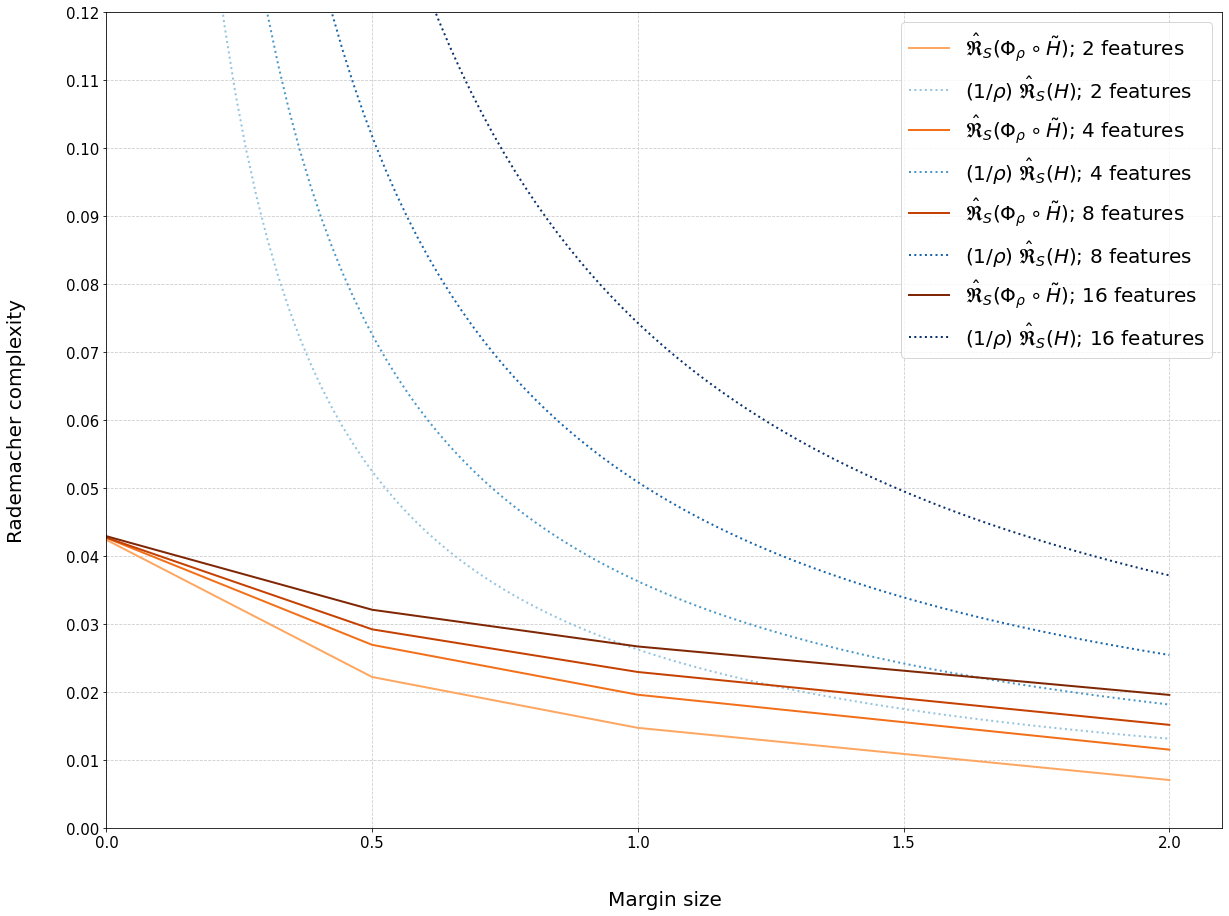

In [19]:
import matplotlib.cm as cm

BOUNDS = np.array([1e-12]) #, 0.5, 1.0])
MARGINS = np.array([0, 0.5, 1.0, 2.0])
dupes = [1, 2, 4, 8]

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=[20,15])

#plt.figure(figsize=[20,15])
color_val = 0.2
for index, dupe in enumerate(dupes):
    color_val += 0.2
    
    cmain = cm.Oranges(color_val)
    csub = cm.Blues(color_val)
    
    for b in BOUNDS: 
        com = []
        for mar in MARGINS:

            h = load_file("histories/dupes/voice_dupes"+str(dupe)+"_maxiter100_margin_loss_b" + str(b) + '_m' + str(mar))
            com.append(calc_complexity(h))

        linear_rad = calc_complexity( load_file("histories/dupes/voice_dupes"+str(dupe)+"_maxiter100_confidence_b"+str(b)) )
        print(linear_rad)

        plt.plot(MARGINS, com, c=cmain, lw=2, label=r'$\hat{\mathfrak{R}}_{S}(\Phi_\rho \circ \tilde{H})$; '+str((dupe-1)*2 + 2)+' features')
        sp = np.linspace(0,2,100)
        yy = np.ones(len(sp)-1)*(linear_rad)/sp[1:]
        yy = np.insert(yy,0,None)
        plt.plot(sp, yy, lw=2, c=csub, label=r'$(1/\rho)\;\hat{\mathfrak{R}}_{S}(H)$; '+str((dupe-1)*2 + 2)+' features', ls=':')



plt.ylim(0,0.12)
plt.xlim(0,2.1)

ax.minorticks_on()
ax.grid(True, which='both')

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.01))

ax.xaxis.set_minor_locator(AutoMinorLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(0.05))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':',lw=3)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20)

plt.xlabel("Margin size", fontsize=20, labelpad=40)
plt.ylabel("Rademacher complexity", fontsize=20, labelpad=40)
#plt.title(r'Rademacher complexity $(\mathfrak{R}_\mathfrak{m}(\Phi_\rho \circ \tilde{H}))$ versus bound $((1/\rho)\;\mathfrak{R}_\mathfrak{m}(H))$', fontsize=20, pad=40)

plt.savefig("images/VOICE_DUPES.png", bbox_inches='tight')

plt.show()


0.02623182510564436
0.03628259582522248
0.050867539916485384
0.07428743830494386


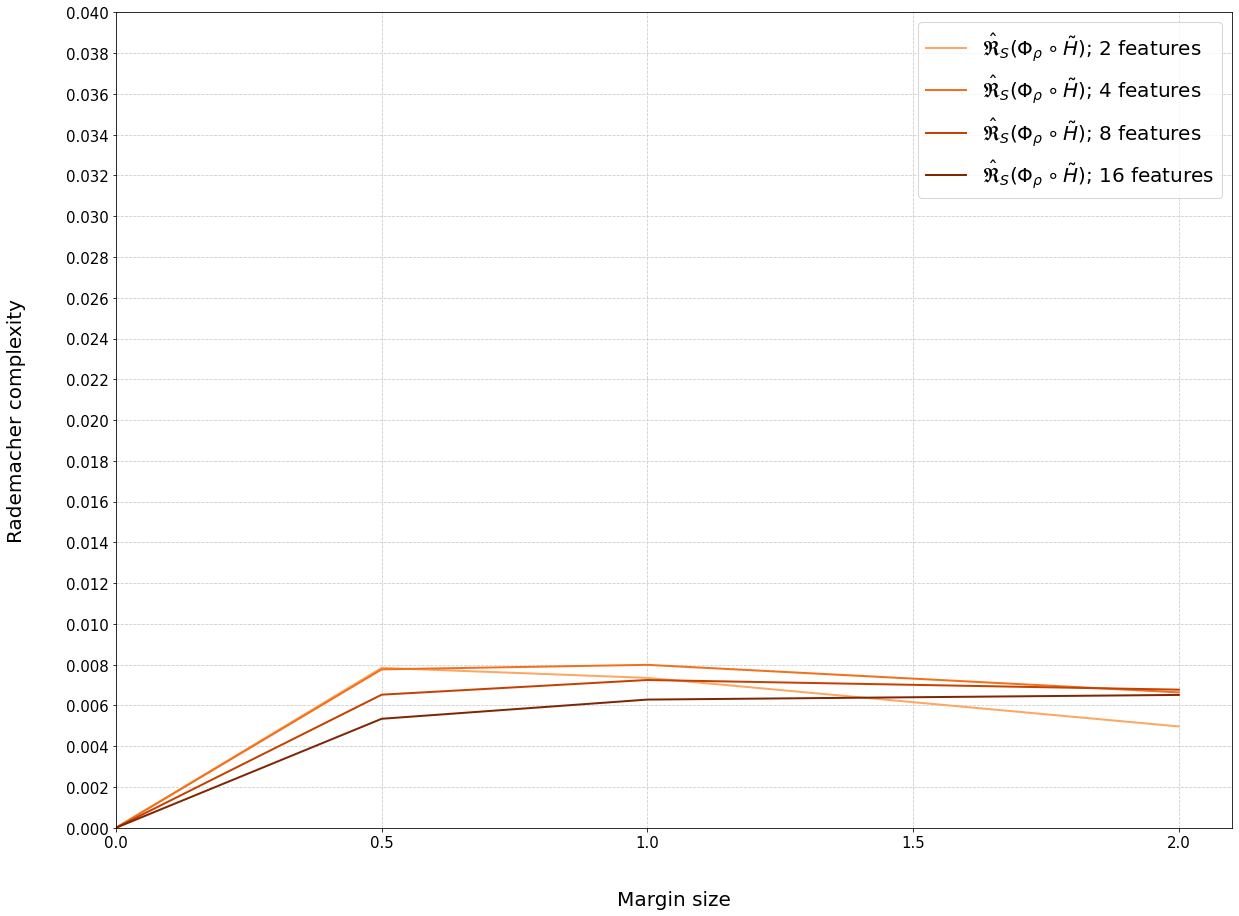

In [22]:
import matplotlib.cm as cm

BOUNDS = np.array([1e-12]) #, 0.5, 1.0])
MARGINS = np.array([0, 0.5, 1.0, 2.0])
dupes = [1, 2, 4, 8]

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=[20,15])

#plt.figure(figsize=[20,15])
color_val = 0.2
for index, dupe in enumerate(dupes):
    color_val += 0.2
    
    cmain = cm.Oranges(color_val)
    csub = cm.Blues(color_val)
    
    for b in BOUNDS: 
        com = []
        for mar in MARGINS:

            h = load_file("histories/dupes/voice_dupes"+str(dupe)+"_maxiter100_margin_loss_b" + str(b) + '_m' + str(mar))
            com.append(calc_complexity(h))

        linear_rad = calc_complexity( load_file("histories/dupes/voice_dupes"+str(dupe)+"_maxiter100_confidence_b"+str(b)) )
        print(linear_rad)

        plt.plot(MARGINS, com * np.sqrt(MARGINS) / np.sqrt(np.array(dupe) * 2 + 2), c=cmain, lw=2, label=r'$\hat{\mathfrak{R}}_{S}(\Phi_\rho \circ \tilde{H})$; '+str((dupe-1)*2 + 2)+' features')
        #sp = np.linspace(0,2,100)
        #yy = np.ones(len(sp)-1)*(linear_rad)/sp[1:]
        #yy = np.insert(yy,0,None)
        #plt.plot(sp, yy, lw=2, c=csub, label=r'$(1/\rho)\;\hat{\mathfrak{R}}_{S}(H)$; '+str((dupe-1)*2 + 2)+' features', ls=':')



plt.ylim(0,0.04)
plt.xlim(0,2.1)

ax.minorticks_on()
ax.grid(True, which='both')

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.002))

ax.xaxis.set_minor_locator(AutoMinorLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(0.05))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':',lw=3)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20)

plt.xlabel("Margin size", fontsize=20, labelpad=40)
plt.ylabel("Rademacher complexity", fontsize=20, labelpad=40)
#plt.title(r'Rademacher complexity $(\mathfrak{R}_\mathfrak{m}(\Phi_\rho \circ \tilde{H}))$ versus bound $((1/\rho)\;\mathfrak{R}_\mathfrak{m}(H))$', fontsize=20, pad=40)

plt.savefig("images/VOICE_DUPES-e1.png", bbox_inches='tight')

plt.show()


### graph 2

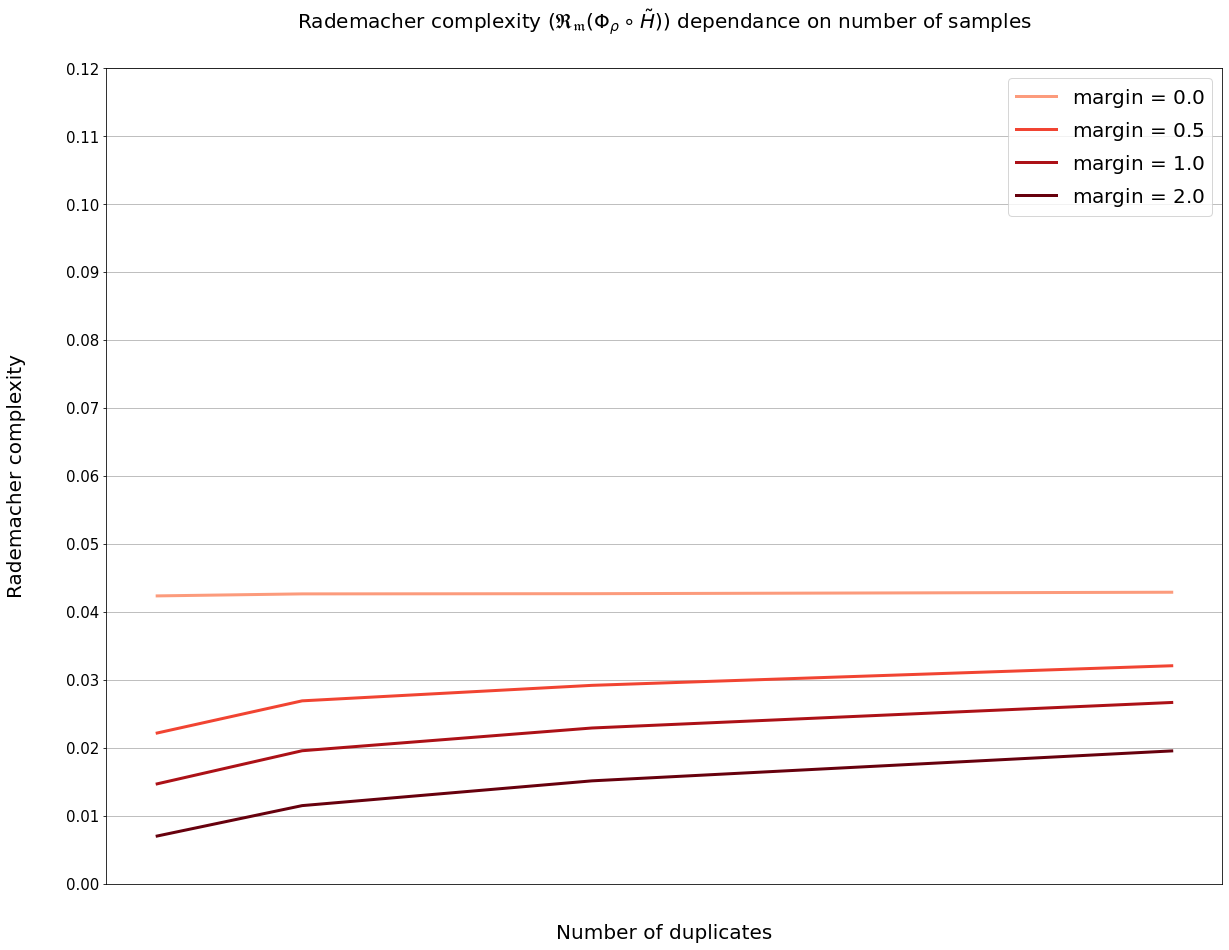

In [3]:
import matplotlib.cm as cm

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

BOUNDS = np.array([1e-12])
MARGINS = np.array([0, 0.5, 1.0, 2.0])

fig, ax = plt.subplots(figsize=[20,15])

#plt.figure(figsize=[20,15])
color_val = 0.1


dupes = [1, 2, 4, 8]

for BOUND in BOUNDS:
    for mar in MARGINS:
        color_val += 0.25
        cmain = cm.Reds(color_val)        
        com = []
        for dupe in dupes:
            h = load_file("histories/dupes/voice_dupes"+str(dupe)+"_maxiter100_margin_loss_b" + str(b) + '_m' + str(mar))
            com.append(calc_complexity(h))
        
        plt.plot(dupes, com, c=cmain, lw=3, label=r'margin = $'+str(mar)+'$')


plt.ylim(0,0.12)
#plt.xlim(-0.5,2.5)

#ax.minorticks_on()
ax.grid(True, which='both')

ax.xaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_major_locator(MultipleLocator(0.01))

#ax.xaxis.set_minor_locator(AutoMinorLocator(100))
#ax.yaxis.set_minor_locator(AutoMinorLocator(0.05))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
#ax.grid(which='major', color='#CCCCCC', linestyle='--')
#ax.grid(which='minor', color='#CCCCCC', linestyle=':',lw=3)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20)

plt.xlabel("Number of duplicates", fontsize=20, labelpad=40)
plt.ylabel("Rademacher complexity", fontsize=20, labelpad=40)
plt.title(r'Rademacher complexity $(\mathfrak{R}_\mathfrak{m}(\Phi_\rho \circ \tilde{H}))$ dependance on number of samples', fontsize=20, pad=40)

plt.savefig("images/VOICE_DUPES2.png")

plt.show()
